In [1]:
import pickle as p
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fnamepickle = '../../data.plk'    
with open(fnamepickle, 'rb') as f:
    [_,ktraj,dcf,_,_] = p.load(f)
with open('../../volunteer3.pkl', 'rb') as f:
    [kdata,pt_signal,si_matrix] = p.load(f)
print(si_matrix.shape)
ncoil = 24

(384, 5749, 24)


In [3]:
data = {'kspace_data':kdata.reshape([-1, 5749, ncoil])[:, 349:-1, ...],
     'trajectory':ktraj.reshape([-1, 5749, 3])[:, 349:-1, ...],
     'dcf':dcf.reshape(-1, 5749, 1)[:, 349:-1, ...] ** 2.0,     
     'nav':si_matrix.reshape(-1, 5749, ncoil)[:, 349:-1, :]} # numbe


In [4]:
fov = {'x':2.0, 'y':2.0, 'z':2.0}
fov_x = fov['x']
fov_y = fov['y']
fov_z = fov['z']

In [5]:
import torch 
import torch.optim as optim
import torch.nn as nn
import cupy as cp
import sigpy as sp
import matplotlib.pyplot as plt

mempool = cp.get_default_memory_pool()
gpu_id = 1

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpatialTransformer(nn.Module):
    #initializer
    def __init__(self,inshape,mode='bilinear'):
        super().__init__()
        
        self.mode = mode
        
        device = torch.device(gpu_id)
        vectors = [torch.arange(0, s) for s in inshape]
        grids = torch.meshgrid(vectors)
        grid = torch.stack(grids)
        grid = torch.unsqueeze(grid, 0)
        grid = grid.type(torch.FloatTensor)
        self.grid = grid.to(device)
        
    def forward(self,inp,flow):
        #print(inp.shape)
        #print(flow.shape)
        new_locs = self.grid + flow
        shape = flow.shape[2:]
        
        for i in range(len(shape)):
            new_locs[:, i, ...] = 2 * (new_locs[:, i, ...] / (shape[i] - 1) - 0.5)
        
        if len(shape) == 2:
            new_locs = new_locs.permute(0, 2, 3, 1)
            new_locs = new_locs[..., [1, 0]]
        elif len(shape) == 3:
            new_locs = new_locs.permute(0, 2, 3, 4, 1)
            new_locs = new_locs[..., [2, 1, 0]]
            
            
        
        return F.grid_sample(inp, new_locs, align_corners=True, mode=self.mode)


In [7]:
device = torch.device(gpu_id)

class gen(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        d = 24
        
        self.conv_blocks = nn.Sequential(
            nn.Conv3d(3, 30, 1, 1, 0),
            #nn.BatchNorm3d(30),
            nn.Tanh(), # Finish Layer 1 --> 1x1x1
            nn.Conv3d(30, d*8, 3, 1, 1),
            #nn.BatchNorm3d(d*8),
            nn.LeakyReLU(0.2, inplace=True), # Finish Layer 2 --> 1x1x1
            nn.Upsample(scale_factor=2, mode='trilinear'), # NN --> 2x2x2
            nn.Conv3d(d*8, d*4, 3, 1, 1),
            #nn.BatchNorm3d(d*4),
            nn.LeakyReLU(0.2, inplace=True), # Finish Layer 3 --> 2x2x2
            nn.Upsample(scale_factor=2, mode='trilinear'), # NN --> 4x4x4
            nn.Conv3d(d*4, d*4, 3, 1, 1),
            #nn.BatchNorm3d(d*4),
            nn.LeakyReLU(0.2, inplace=True), # Finish Layer 4 --> 4x4x4
            nn.Upsample(scale_factor=2, mode='trilinear'), # NN --> 8x8x8
            nn.Conv3d(d*4, d*2, 3, 1, 1),
            #nn.BatchNorm3d(d*2),
            nn.LeakyReLU(0.2, inplace=True), # Finish Layer 5 --> 8x8x8
            nn.Upsample(scale_factor=2, mode='trilinear'), # NN --> 16x16x16
            nn.Conv3d(d*2, d, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True), # Finish Layer 6 --> 16x16x16
            nn.Upsample(scale_factor=2, mode='trilinear'), # NN --> 32x32x32
            nn.Conv3d(d, d, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True), # Finish Layer 7 --> 32x32x32
            nn.Upsample(scale_factor=2, mode='trilinear'), # NN --> 64x64x64
            nn.Conv3d(d, d, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True), # Finish Layer 7 --> 32x32x32
            nn.Conv3d(d, d, 3, 1, 1),
            nn.LeakyReLU(0.2, inplace=True), # Finish Layer 7 --> 32x32x32
            nn.Conv3d(d, 3, 3, 1, 1),
            nn.Tanh()
            )

            
        self.trans = SpatialTransformer([256, 256, 256], mode='bilinear')
        self.flow = None
        self.x = nn.Parameter(torch.zeros([1, 2, 256, 256, 256]))
        self.upsample = nn.Upsample(size=[256, 256, 256], mode='trilinear')
        
    def weight_init(self):
    
        def init(layer):
            if isinstance(layer, nn.Conv3d):
                torch.nn.init.kaiming_normal_(layer.weight, a=0.2)
            elif isinstance(layer, nn.ConvTranspose3d):
                torch.nn.init.kaiming_normal_(layer.weight, a=0.2)
            
        self.conv_blocks.apply(init)
        
    def resize_output(self, size):
        self.trans = SpatialTransformer([size, size, size], mode='bilinear')
        self.upsample = nn.Upsample(size=[size, size, size])
        self.trans.to(torch.device(gpu_id))
        
    def forward(self, z: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        
        flow = (self.conv_blocks(z))
        flow = self.upsample(flow)
        flow = flow*4.0
        self.flow = flow
        #print(self.flow.shape)
        return self.trans(x, flow)

In [8]:
import sigpy.mri as mri
trajectory = data['trajectory']
ksp = data['kspace_data']
dcf = data['dcf'].reshape([1, -1])
import scipy

avg_trj = trajectory.reshape([-1, 3])
avg_trj = np.array([425/2, 425/2, 425/2]).reshape([1, 3]) * avg_trj / np.max(avg_trj, axis=0).reshape([1, 3])
avg_ksp = ksp.reshape([-1, ncoil]).transpose([1, 0])
avg_ksp = avg_ksp * (dcf) / np.max(abs(avg_ksp))
avg_recon = None
s_map = None

with sp.Device(gpu_id) as device:
    avg_trj_g = cp.array(avg_trj)
    avg_ksp_g = cp.array(avg_ksp)
    avg_recon_g = cp.zeros([ncoil, 256, 256, 256])
    A = sp.linop.NUFFTAdjoint([1, 256, 256, 256], avg_trj_g)
    for i in range(ncoil):
        #print(avg_ksp_g.shape)
        avg_recon_g[i, ...] = A(avg_ksp_g[i, ...].reshape([1, avg_ksp_g.shape[1]])).reshape([256, 256, 256])
    del avg_trj_g
    del avg_ksp_g
    del A
avg_recon = avg_recon_g.get()
del avg_recon_g

with cp.cuda.Device(gpu_id):
    mempool.free_all_blocks()  # 5 GiB
    

/Users/jwkettelkamp/miniconda/envs/factornet_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: ComplexWarning: Casting complex values to real discards the imaginary part


In [9]:

from typing import Tuple

with cp.cuda.Device(gpu_id):
    mempool.free_all_blocks()  # 5 GiB

signalmask =None
    
def coilCombine(ksp, coilimages, image_size, slices, ncoils, vcoils, si_matrix):

    ksp = ksp.transpose([2, 0, 1])
    shape = ksp.shape
    coilimages = coilimages.transpose([0, 3, 1, 2])
    ind = np.linspace(-image_size / 2, image_size / 2, image_size)
    [x, y, z] = np.meshgrid(ind + 0, ind - 0, ind)
    r = np.sqrt(x ** 2 + y ** 2 + z ** 2) 
    signalmask = (abs(r) < image_size / 7)
    noisemask = (abs(r) > image_size / 7) * r

    signal = coilimages * signalmask
    noise = np.zeros((coilimages * noisemask).shape)

    signal = np.reshape(signal, (ncoils, slices * image_size * image_size))
    noise = np.reshape(noise, (ncoils, slices * image_size * image_size))

    A = np.real(signal @ np.conj(np.transpose(signal)))
    B = np.real(noise @ np.conj(np.transpose(noise)))

    [D, W] = scipy.linalg.eig(A, B);
    ind = np.flipud(np.argsort(D))
    W = W[:, ind[0:vcoils]]
    
    W[abs(W) < 0.225] = 0.0

    kspCombined = W.T @ np.reshape(ksp, (ncoils, shape[1] * shape[2]))
    kspCombined = np.reshape(kspCombined, (vcoils, shape[1], shape[2]))
    
    shape = si_matrix.shape
    csim = W.T @ si_matrix.transpose([2, 0, 1]).reshape([ncoils, -1])
    
    return signalmask, kspCombined.transpose([1, 2, 0]), csim.reshape([vcoils, 384, -1]).transpose([1, 2, 0])

nvcoils = 11
sim = data['nav']
signalmask, kspCombine, csim = coilCombine(ksp, avg_recon, 256, 256, ncoil, nvcoils, sim)

In [10]:


avg_trj = trajectory.reshape([-1, 3])
avg_trj = np.array([425/2, 425/2, 425/2]).reshape([1, 3]) * avg_trj / np.max(avg_trj, axis=0).reshape([1, 3])
avg_ksp = kspCombine.reshape([-1, nvcoils]).transpose([1, 0])
print(avg_ksp.shape)
avg_ksp = avg_ksp * (dcf) / np.max(abs(avg_ksp))
avg_recon = None
s_map = None
e_s_map = None
with sp.Device(gpu_id) as device:
    avg_trj_g = cp.array(avg_trj)
    avg_ksp_g = cp.array(avg_ksp)
    A = sp.linop.NUFFTAdjoint([nvcoils, 256, 256, 256], avg_trj_g)
    avg_recon = A(avg_ksp_g)
    FFT = sp.linop.FFT([nvcoils, 256, 256, 256], axes=[-1, -2, -3])
    cart_ksp = FFT(avg_recon)
    del A
    del FFT
with sp.Device(gpu_id) as device:
    s_map = mri.app.JsenseRecon(avg_ksp_g,coord=avg_trj_g,img_shape=[256,256,256],ksp_calib_width=6, mps_ker_width=16, device=device).run()
    del avg_ksp_g
    del avg_trj_g
avg_recon = avg_recon.get()
with sp.Device(gpu_id) as device:
    avg_trj_g = cp.array(avg_trj)
    avg_ksp_g = cp.array(avg_ksp)
    A = sp.linop.NUFFTAdjoint([nvcoils, 256, 256, 256], avg_trj_g)
    avg_recon = A(avg_ksp_g)
    del A
    del avg_ksp_g
    del avg_trj_g
avg_recon = avg_recon.get()

with cp.cuda.Device(gpu_id):
    mempool.free_all_blocks()  # 5 GiB

(11, 43537536)


(11, 256, 256, 256)
(11, 256, 256, 256)


<Figure size 432x288 with 0 Axes>

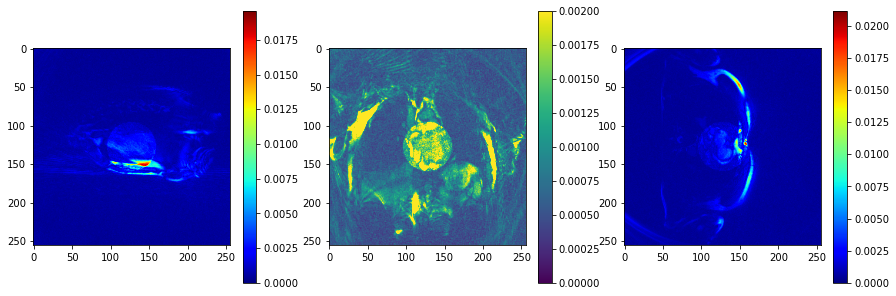

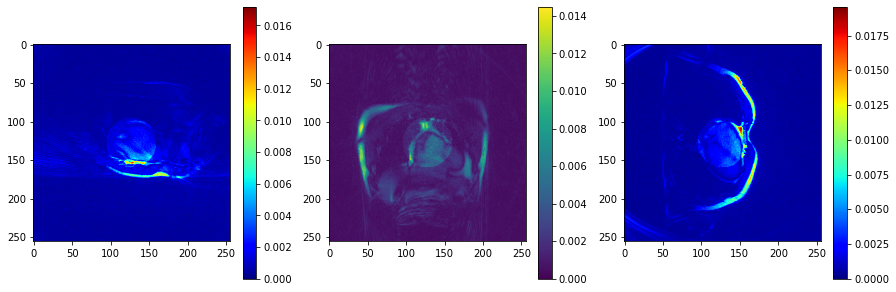

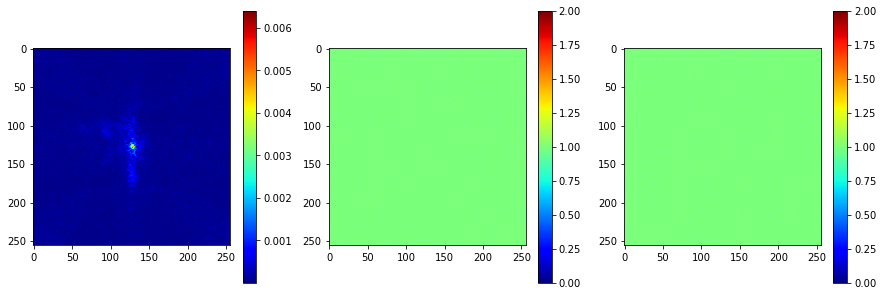

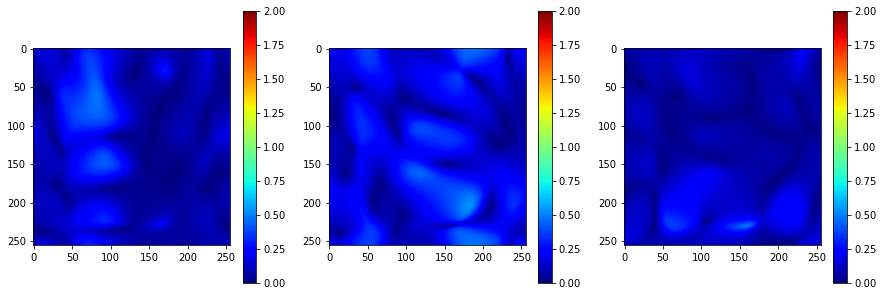

In [11]:
print(avg_recon.shape)
print(s_map.shape)
plt.figure()
ssr = np.sqrt(np.sum(abs(avg_recon) ** 2, axis=0))
ss = np.sum(abs((s_map[:, :, :, :])**2), axis=0)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sos =  (signalmask + 0.9) * np.sqrt(np.sum(abs(avg_recon ** 2), axis=0))
img1 = axs[0].imshow(sos[110, :, :], cmap='jet', vmin=0.0)#, vmax=0.0004)
img2 = axs[1].imshow(sos[:,110, :].transpose([ 1, 0]), vmin=0.0, vmax=0.002)
img3 = axs[2].imshow(sos[:, :,110], cmap='jet', vmin=0.0)#, vmax=0.0004)
plt.colorbar(img1, ax=axs[0])
plt.colorbar(img2, ax=axs[1])
plt.colorbar(img3, ax=axs[2])
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
sos =  (signalmask + 0.9) * np.sqrt(np.sum(abs(avg_recon ** 2), axis=0))
img1 = axs[0].imshow(sos[144, :, :], cmap='jet', vmin=0.0)#, vmax=0.0004)
img2 = axs[1].imshow(sos[:,144, :].transpose([ 1, 0]), vmin=0.0)
img3 = axs[2].imshow(sos[:, :,144], cmap='jet', vmin=0.0)#, vmax=0.0004)
plt.colorbar(img1, ax=axs[0])
plt.colorbar(img2, ax=axs[1])
plt.colorbar(img3, ax=axs[2])
plt.show()

index = torch.arange(9,10000,18)
ss = np.sum(abs((s_map[:, :, :, :])**2), axis=0)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
img1 = axs[0].imshow(abs(cart_ksp[1, :,110, :].get()), cmap='jet')
img2 = axs[1].imshow(ss[...,7], cmap='jet', vmin=0.0, vmax=2.0)
img3 = axs[2].imshow(ss[...,15], cmap='jet', vmin=0.0, vmax=2.0)
plt.colorbar(img1, ax=axs[0])
plt.colorbar(img2, ax=axs[1])
plt.colorbar(img3, ax=axs[2])
plt.show()
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
img1 = axs[0].imshow(abs(s_map[1, ...,110]), cmap='jet', vmin=0.0, vmax=2.0)
img2 = axs[1].imshow(abs(s_map[2, ...,110]), cmap='jet', vmin=0.0, vmax=2.0)
img3 = axs[2].imshow(abs(s_map[3, ...,110]), cmap='jet', vmin=0.0, vmax=2.0)
plt.colorbar(img1, ax=axs[0])
plt.colorbar(img2, ax=axs[1])
plt.colorbar(img3, ax=axs[2])
plt.show()

In [12]:
from typing import Tuple, Union, Optional

class Encoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, conditional):

        super().__init__()

        self.conditional = conditional
        self.ls = layer_sizes[0]
            
        if self.conditional:
            layer_sizes[0] += 1

        self.MLP = nn.Sequential()
        
        for i, (in_size, out_size) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
            self.MLP.add_module(
                  name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            self.MLP.add_module(name="A{:d}".format(i), module=nn.LeakyReLU(0.2))

        self.linear_means = nn.Linear(layer_sizes[-1], latent_size)
        self.linear_log_var = nn.Linear(layer_sizes[-1], latent_size)

    def forward(self, x: torch.Tensor, c: Optional[torch.Tensor]=None) -> Tuple[torch.Tensor, torch.Tensor]:

        if self.conditional:
            x = torch.cat((x, c), dim=-1)
                
        x = self.MLP(x)

        means = self.linear_means(x)
        log_vars = self.linear_log_var(x)

        return means, log_vars

    
    #       Decoder for initial latent vector estimation   
    #---------------------
class Decoder(nn.Module):

    def __init__(self, layer_sizes, latent_size, conditional):

        super().__init__()

        self.MLP = nn.Sequential()
        self.ls = latent_size

        self.conditional = conditional
        if self.conditional:
            input_size = latent_size + 1
        else:
            input_size = latent_size

        for i, (in_size, out_size) in enumerate(zip([input_size]+layer_sizes[:-1], layer_sizes)):
            self.MLP.add_module(
                    name="L{:d}".format(i), module=nn.Linear(in_size, out_size))
            if i+1 < len(layer_sizes):
                self.MLP.add_module(name="A{:d}".format(i), module=nn.LeakyReLU(0.2))
            #else:
            #    self.MLP.add_module(name="sigmoid", module=nn.Sigmoid())

    def forward(self, z: torch.Tensor, c: Optional[torch.Tensor]=None):
            
        if self.conditional:
            z = torch.cat((z, c), dim=-1)
                
        x = self.MLP(z)

        return x

    #       VAE for initial latent vector estimation  
    #---------------------

class VAE(nn.Module):

    def __init__(self, encoder_layer_sizes: list, latent_size: int, decoder_layer_sizes: list, nframes: int, FTR: float, nskip: int,  conditional: bool = False) -> None:
        super().__init__()

        assert type(encoder_layer_sizes) == list
        assert type(latent_size) == int
        assert type(decoder_layer_sizes) == list
            
        self.FTR = FTR
        self.nframes = nframes
        self.nskip = nskip
            
        F = 1 / self.FTR
        frange = np.fft.fftshift(torch.linspace(-F / 2, F / 2, self.nframes))
            
        self.encoder = Encoder(
              encoder_layer_sizes, latent_size, conditional)
        self.decoder = Decoder(
              decoder_layer_sizes, latent_size, conditional)
          
    def weight_init(self):
    
        def init(layer):
            if isinstance(layer, nn.Conv3d):
                torch.nn.init.kaiming_normal_(layer.weight, a=0.2)
            elif isinstance(layer, nn.ConvTranspose3d):
                torch.nn.init.kaiming_normal_(layer.weight, a=0.2)
            
        self.encoder.apply(init)
        self.decoder.apply(init)
            
    def forward(self, x: torch.Tensor) -> torch.Tensor:

        means, log_var = self.encoder(x)
            
        z = self.reparameterize(means, log_var)
        recon_x = self.decoder(z)

        return recon_x, means, log_var, z

    def reparameterize(self, mu: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:

        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)

        return mu + eps * std
        


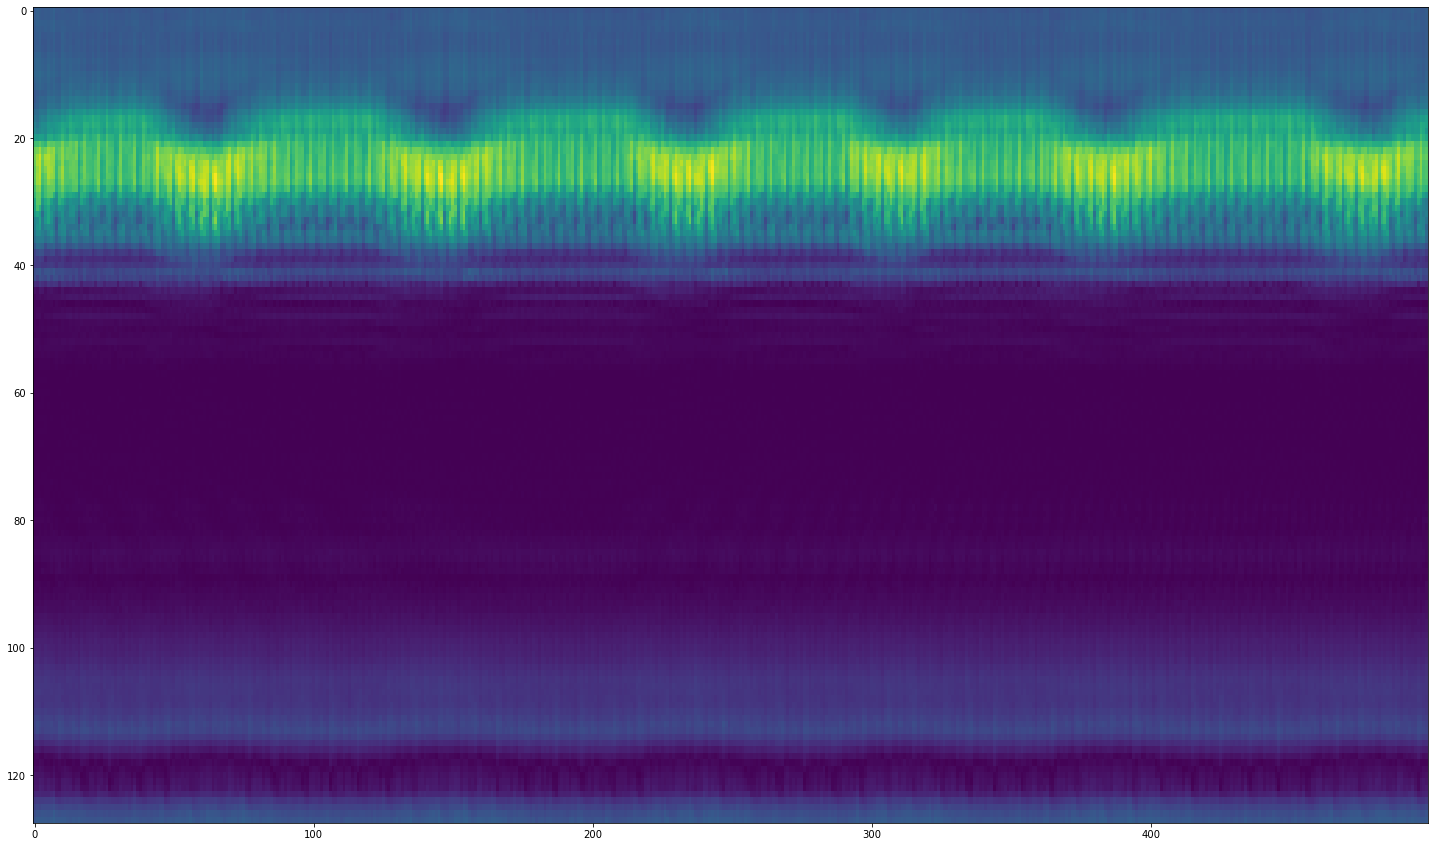

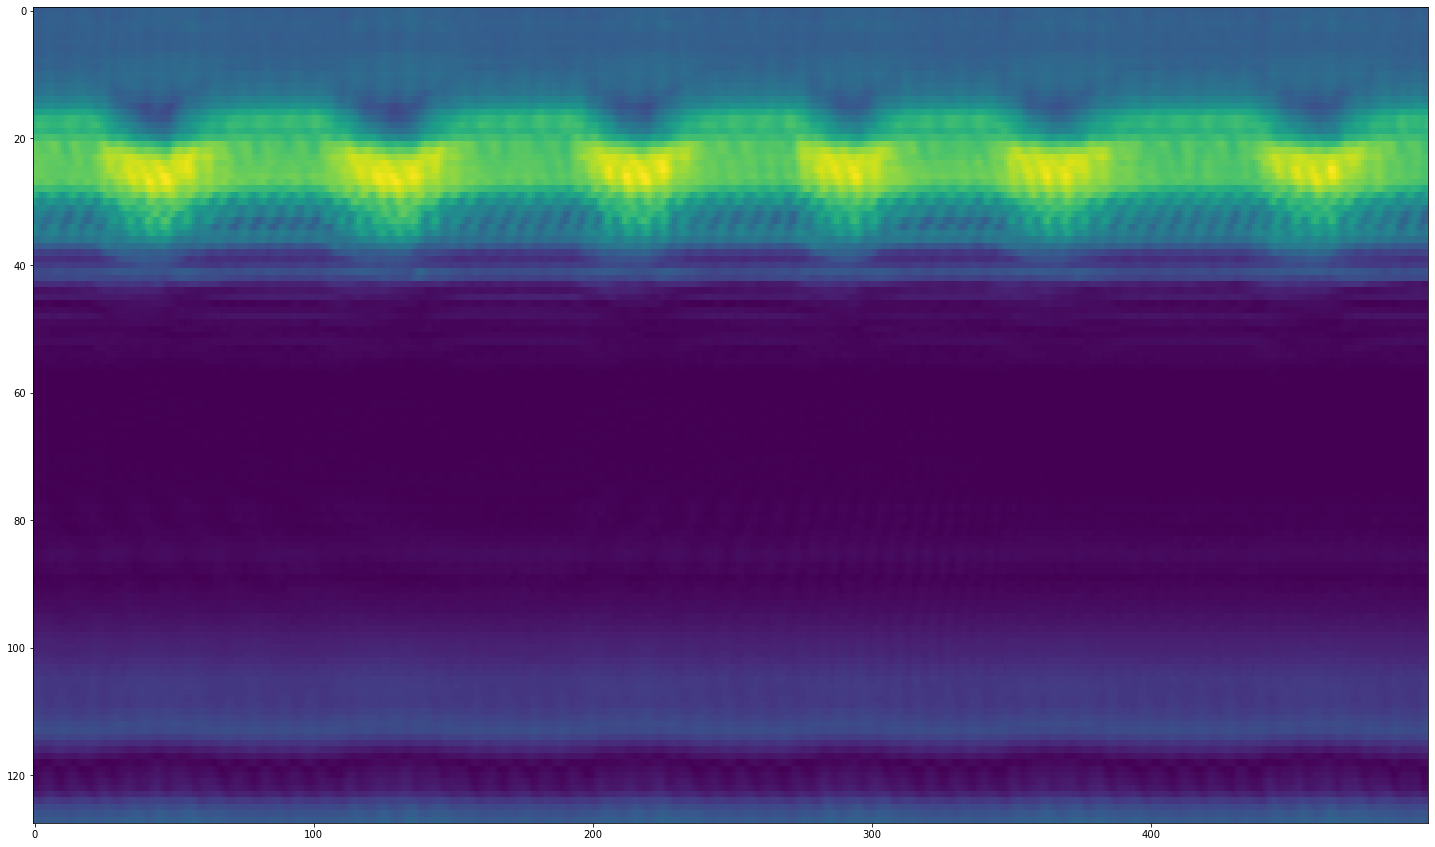

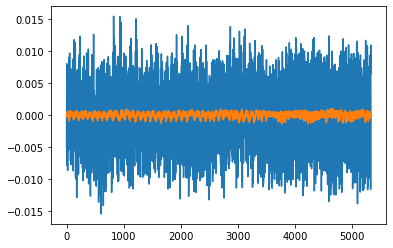

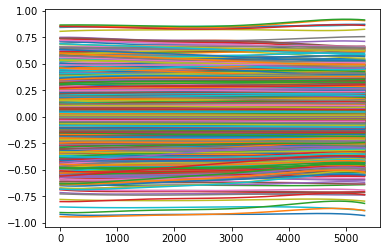

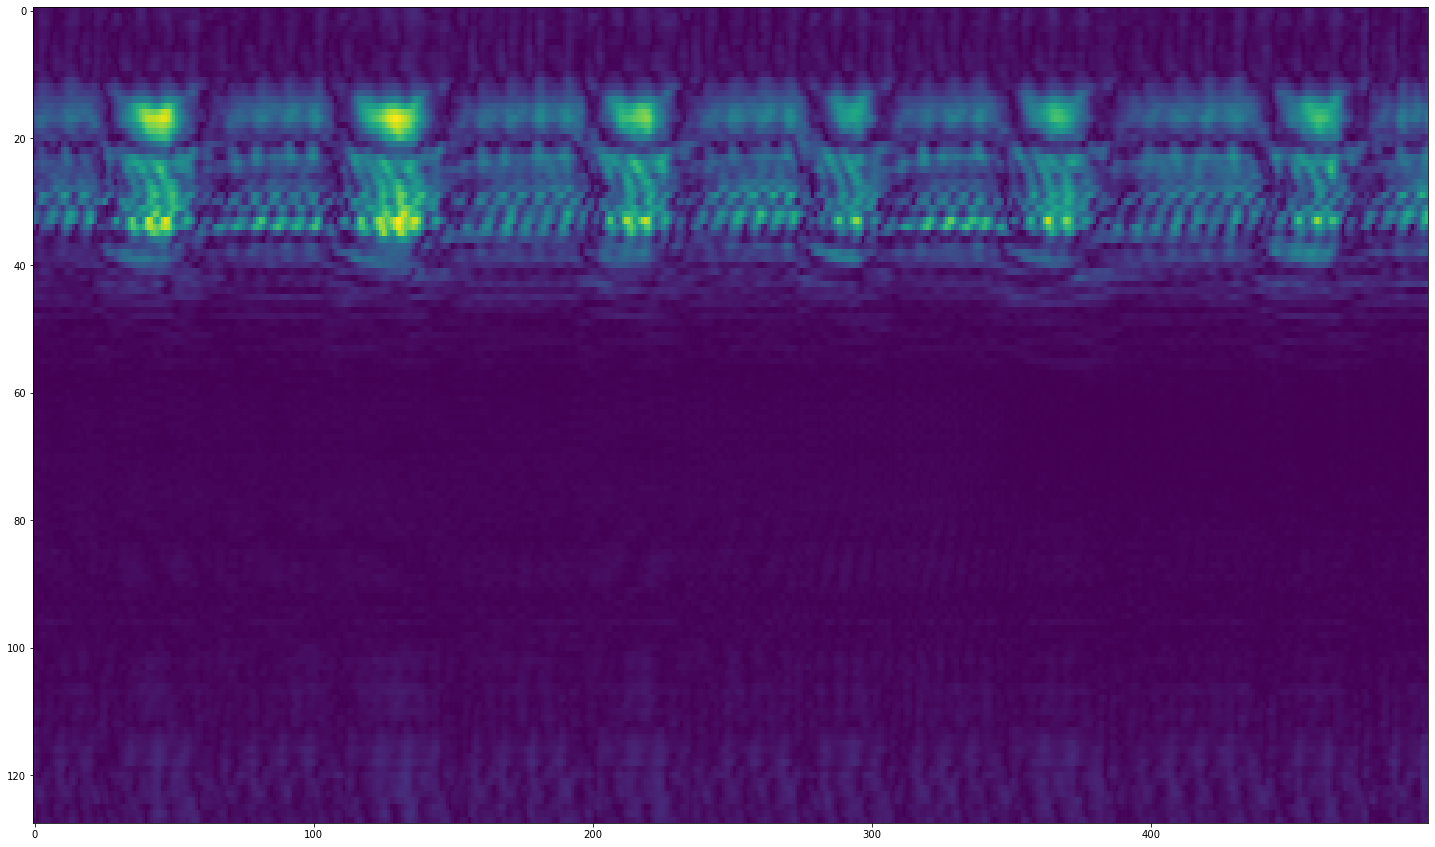

In [13]:
def detrend(nav,npoly):
    x = np.linspace(-1,1,nav.shape[0])
    navout = nav
    for i in range(nav.shape[1]):
        z = np.polyfit(x, nav[:,i], npoly)
        out = np.polyval(z,x)
        navout[:,i] =  nav[:,i]-out
    return navout

start = 18*0+9
idx = np.arange(start,14778,18)
ccoils = [2, 4, 5, 12, 16, 17]
nav = data['nav'].transpose([1, 0, 2])

nav = np.fft.ifft(np.fft.ifftshift(nav[:, int(384/2 - 64):int(384 /2 + 64), ...], axes=1), axis=1).transpose([0, 2, 1]).reshape([nav.shape[0], 128 * nav.shape[2]])[25:-25, ...]

plt.figure(figsize=(25,15))
plt.imshow(abs(nav)[:500, 128:256].T, interpolation='nearest', aspect='auto')
plt.show()

NAV = torch.fft.fftshift(torch.fft.fft(torch.tensor(nav).to(torch.device(gpu_id)), axis=0), axis=0).cpu().numpy()
FTR= 3.14e-3 * 22
scan_time = nav.shape[0] * FTR
frequencies = np.linspace(-(1.0 / FTR) / 2.0, (1.0 / FTR) / 2.0, nav.shape[0])
bandstop = (abs(frequencies) < 2.8)
bandstop = np.reshape(bandstop,[-1, 1])

nav = torch.fft.ifft(torch.fft.ifftshift(torch.tensor(NAV * bandstop).to(torch.device(gpu_id)), axis=0), axis=0).cpu().numpy()
nav = nav/np.max(np.abs(nav))
nav = nav[18:-1,:]

plt.figure(figsize=(25,15))
plt.imshow(abs(nav)[:500, 128:256].T, interpolation='nearest', aspect='auto')
plt.show()

nav = np.concatenate((np.real(nav),np.imag(nav)),axis=1)
i=0
from numpy.polynomial import Chebyshev
t = np.linspace(0.0, 1.0, nav.shape[0])
corre = np.zeros(nav.shape)
for coil in range(nav.shape[1]):
    c = Chebyshev.fit(t, nav[..., coil], deg=5)
    corre[..., coil] = c(t)
    nav[..., coil] = nav[..., coil] - corre[..., coil]
s=plt.plot(nav[:,i])
s=plt.plot(np.mean(nav[:,:], axis=1))
plt.show()
plt.figure()
s=plt.plot(corre)
plt.show()

device = torch.device(gpu_id)
navT = torch.tensor(nav,dtype=torch.float).to(device)

plt.figure(figsize=(25,15))
plt.imshow(abs(torch.view_as_complex(torch.tensor(nav.reshape([nav.shape[0], 2, -1]).transpose([0, 2, 1])).contiguous()).numpy())[:500, 128:256].T, interpolation='nearest', aspect='auto')
plt.show()

In [14]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
navT = navT.reshape([navT.shape[0], -1])
def norm(x):
    return (x - np.mean(x, axis=0).reshape([1, -1]))/np.max((x - np.mean(x, axis=0).reshape([1, -1])), axis=0).reshape([1, -1])

device = torch.device(gpu_id)

encoder_layer_sizes = list([navT.shape[1],256,48,16,8])
decoder_layer_sizes = list([8,16,48,256,navT.shape[1]])
lm_network = VAE(encoder_layer_sizes, 3, decoder_layer_sizes, nav.shape[0], FTR, 0, conditional=False).to(device)
lm_network.weight_init()
recon_x, means, log_var, z = lm_network(navT)

opt = optim.Adam([{'params': lm_network.parameters(), 'lr': 1e-4}])

loss_fn = nn.L1Loss()
lam = 8e-10
frequencies = np.linspace(-(1.0 / FTR) / 2.0, (1.0 / FTR) / 2.0, nav.shape[0])
BadBand = np.zeros([nav.shape[0], 3])
BadBand[:, 0] =  3.0e2 * ((abs(frequencies) >= 0.05) * ((abs(frequencies) <= 0.95)))# + 1e1 * (abs(frequencies) > 2.5)
BadBand[:, 1] =  1.0e2 * ((abs(frequencies) < 0.01) + (abs(frequencies) > 0.9))# + 1e0
BadBand[:, 2] =  1.0e2 * ((abs(frequencies) < 0.01) + (abs(frequencies) > 0.9))
BadBand = torch.tensor(BadBand).to(device)

Data:  0.14933790266513824 Total:  0.1498466749041689


<Figure size 432x288 with 0 Axes>

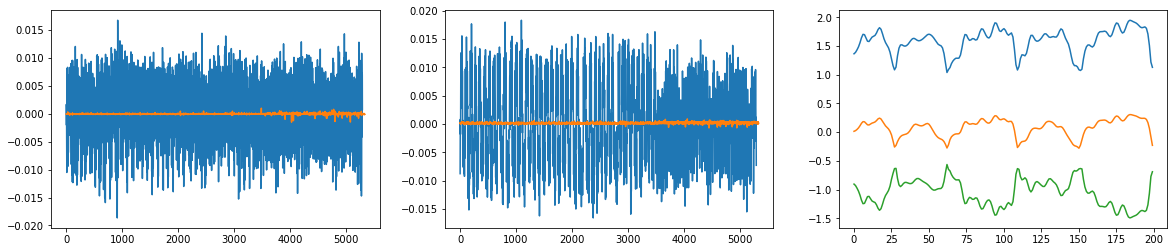

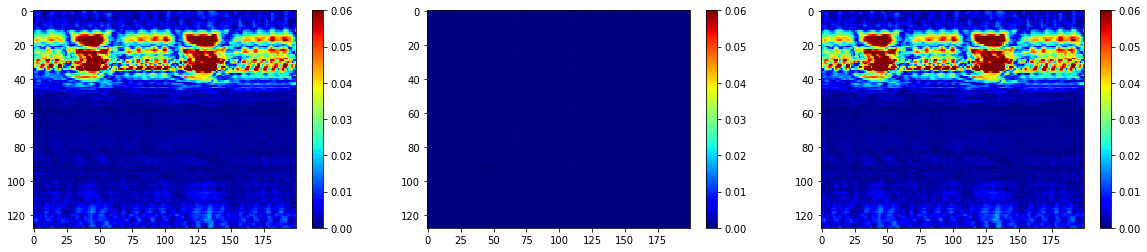

Data:  0.1005297526717186 Total:  0.10119723913596576


<Figure size 432x288 with 0 Axes>

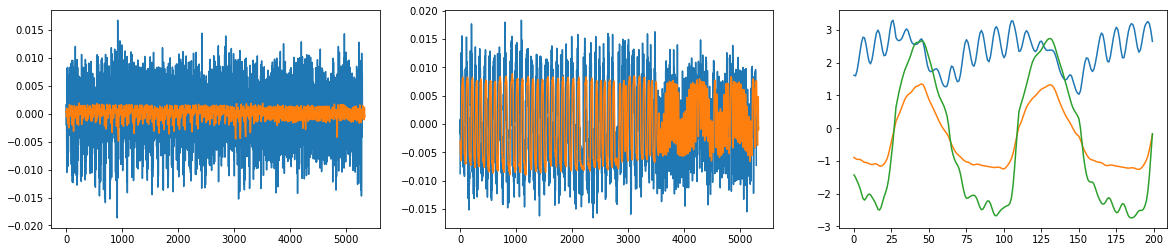

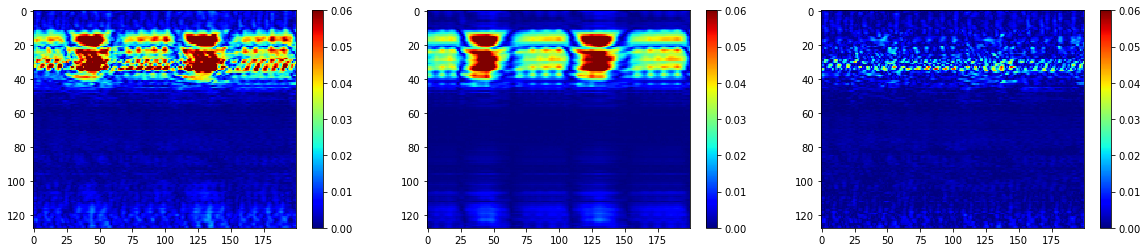

Data:  0.09271793812513351 Total:  0.09298333525711928


<Figure size 432x288 with 0 Axes>

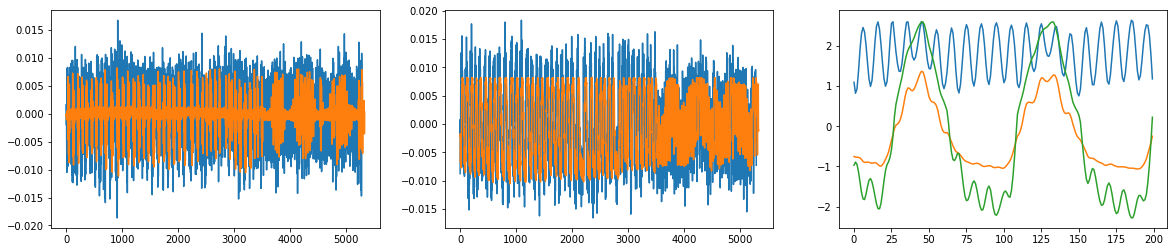

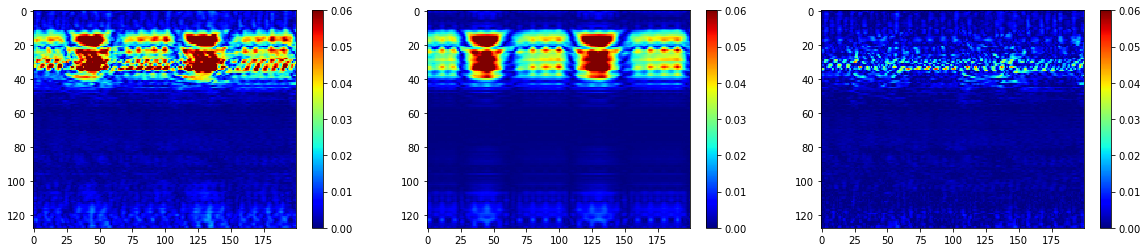

Data:  0.09158896654844284 Total:  0.09178807121065305


<Figure size 432x288 with 0 Axes>

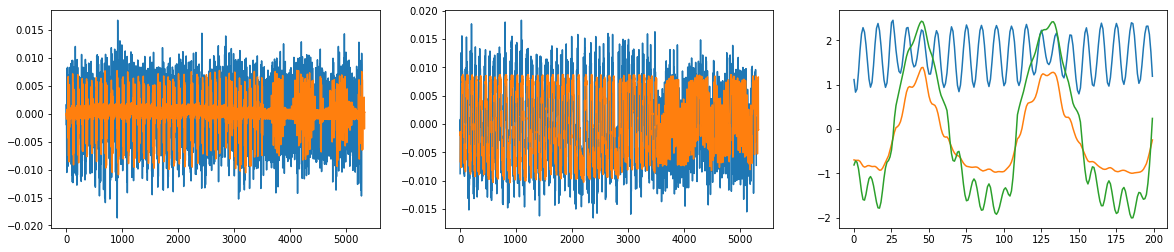

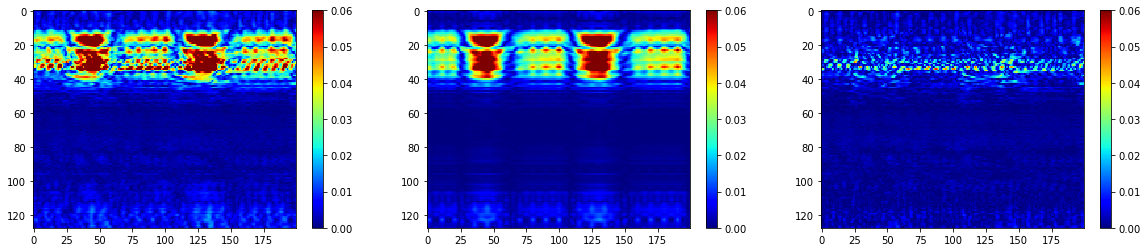

Data:  0.08729531615972519 Total:  0.08823776840888017


<Figure size 432x288 with 0 Axes>

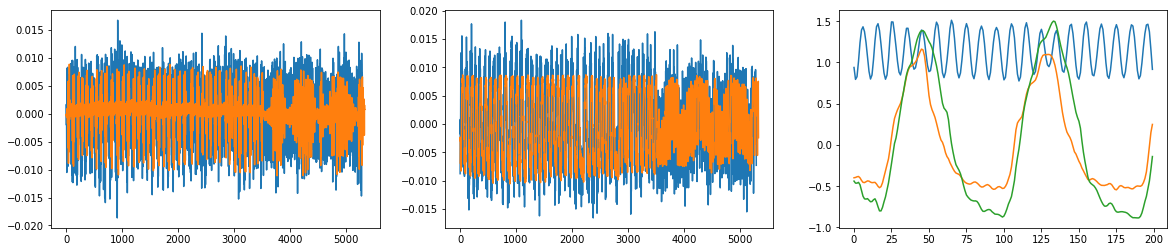

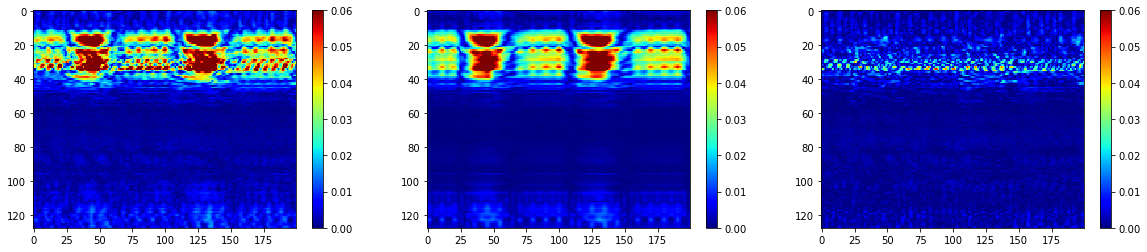

Data:  0.08456951379776001 Total:  0.08530202447928245


<Figure size 432x288 with 0 Axes>

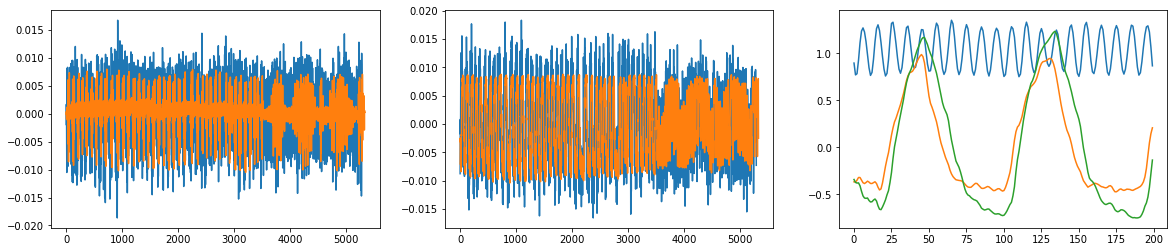

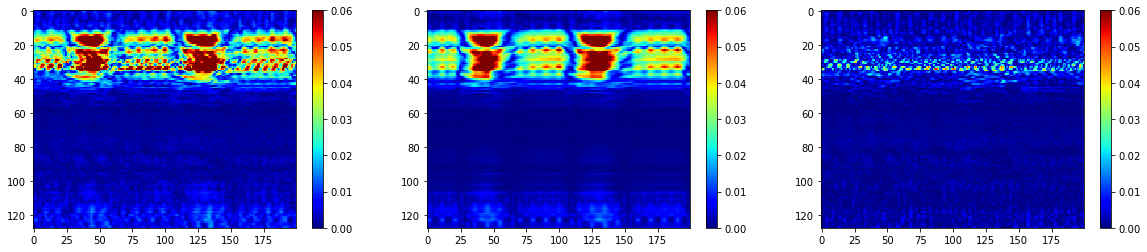

Data:  0.08400381356477737 Total:  0.08466188281191626


<Figure size 432x288 with 0 Axes>

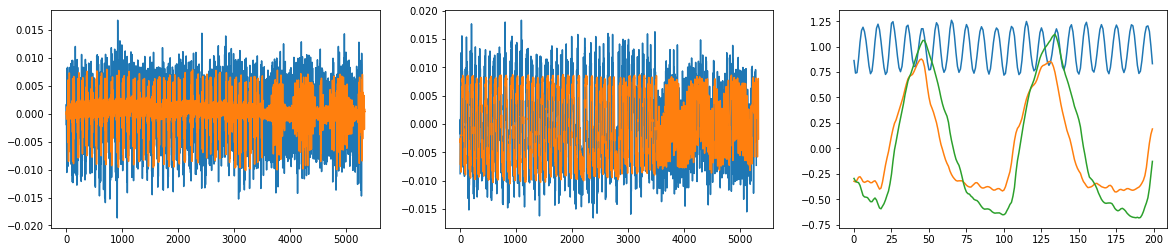

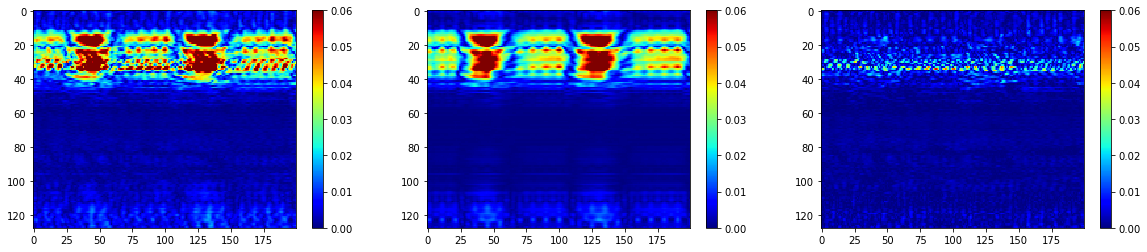

Data:  0.08368726819753647 Total:  0.08430082795223817


<Figure size 432x288 with 0 Axes>

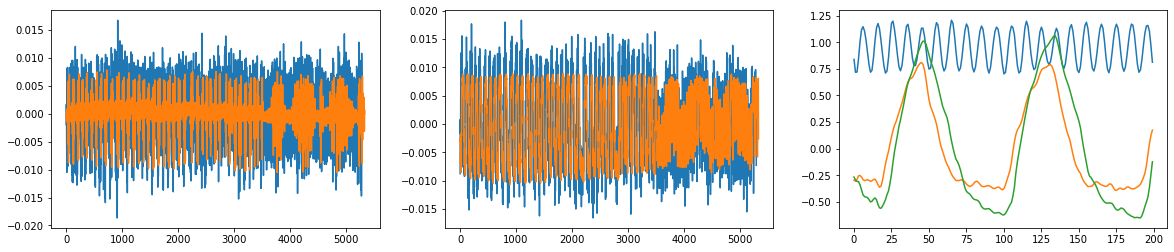

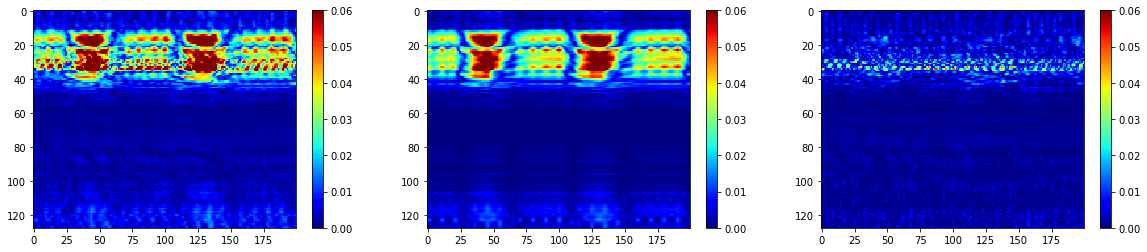

Data:  0.08348498493432999 Total:  0.08406971830800011


<Figure size 432x288 with 0 Axes>

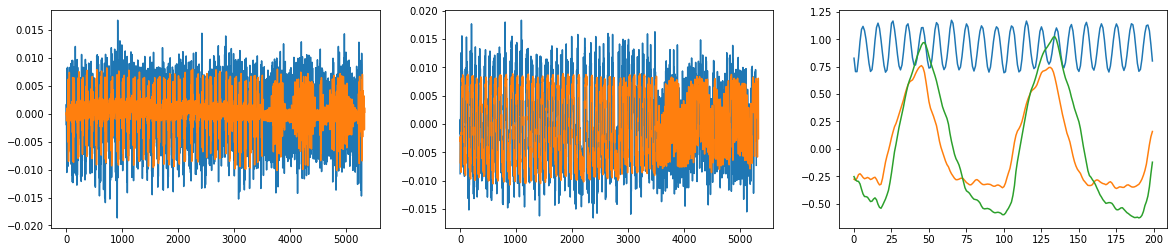

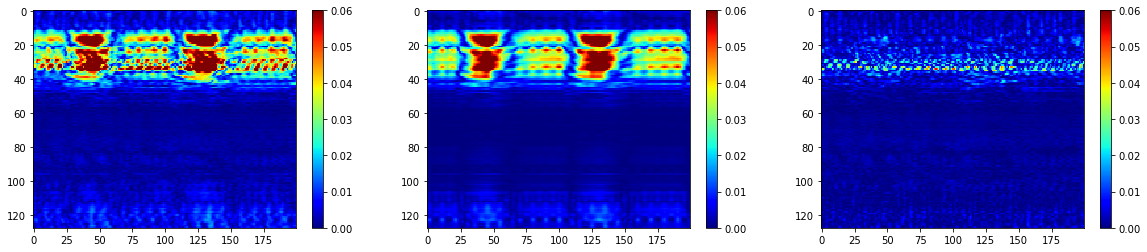

Data:  0.08331318199634552 Total:  0.08387736772805324


<Figure size 432x288 with 0 Axes>

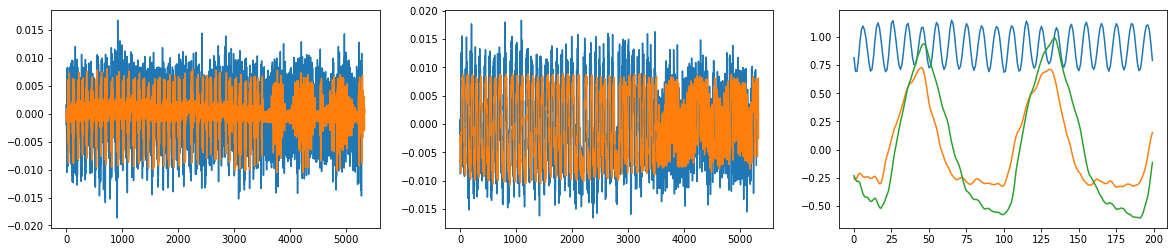

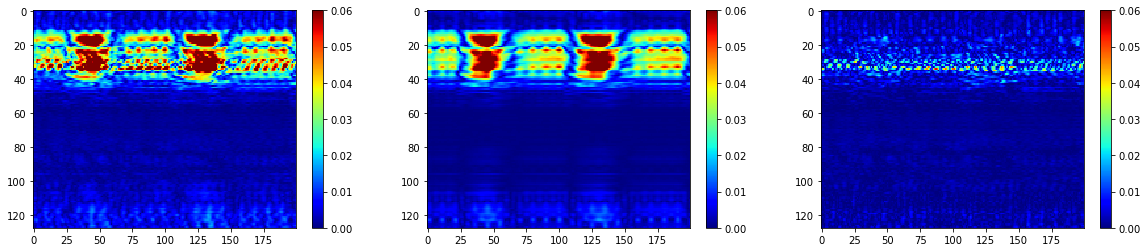

Data:  0.08317403495311737 Total:  0.08372656613307518


<Figure size 432x288 with 0 Axes>

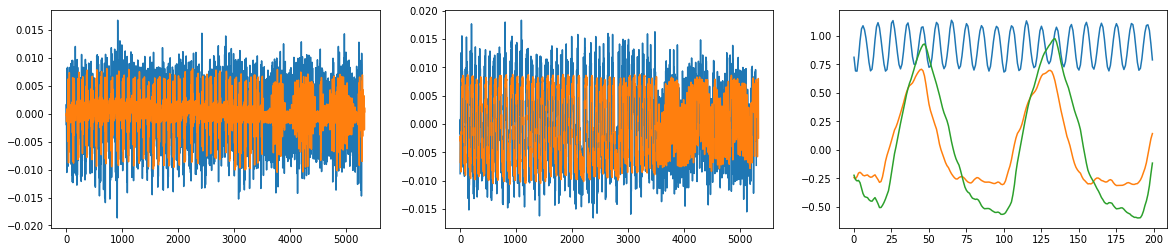

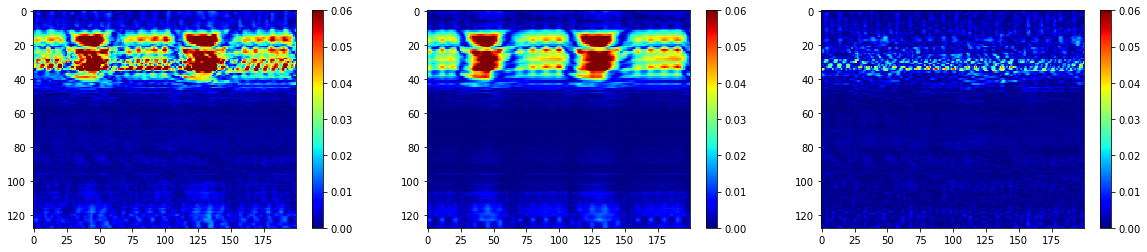

Data:  0.083041250705719 Total:  0.08358568263007493


<Figure size 432x288 with 0 Axes>

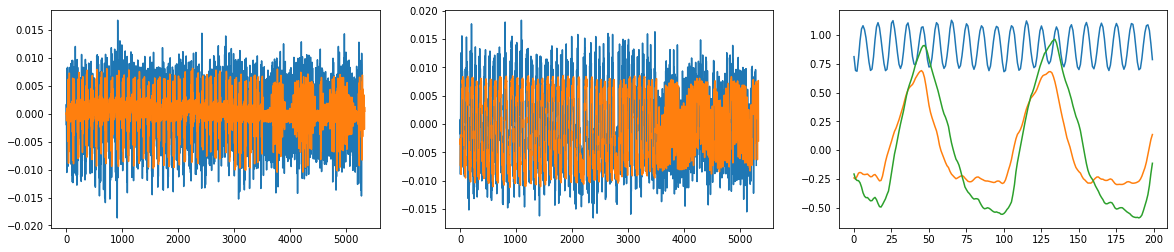

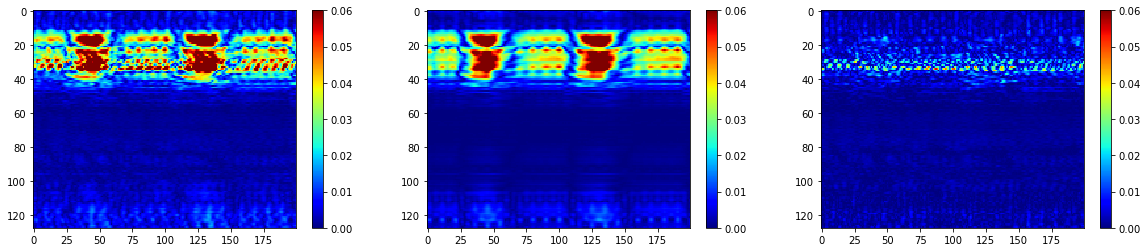

Data:  0.08288516849279404 Total:  0.08342169735271246


<Figure size 432x288 with 0 Axes>

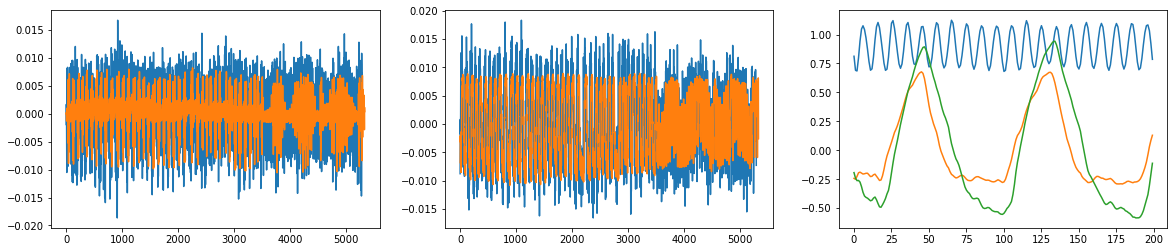

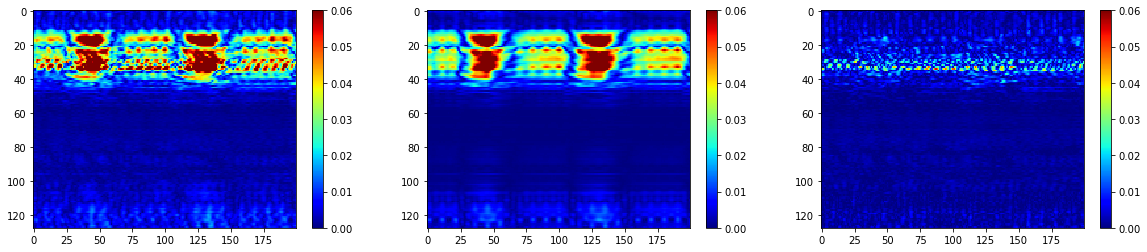

Data:  0.08280022442340851 Total:  0.08333007810077665


<Figure size 432x288 with 0 Axes>

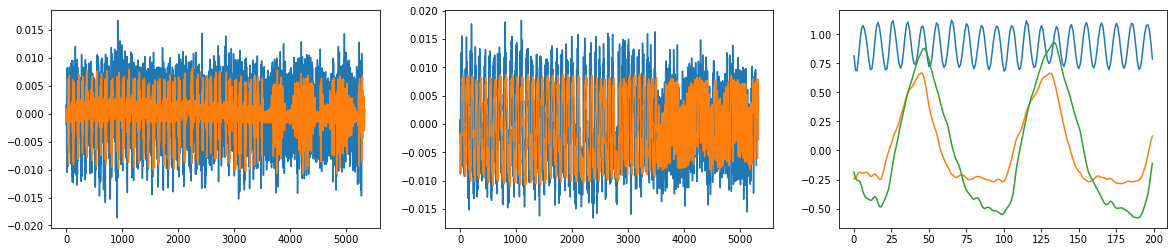

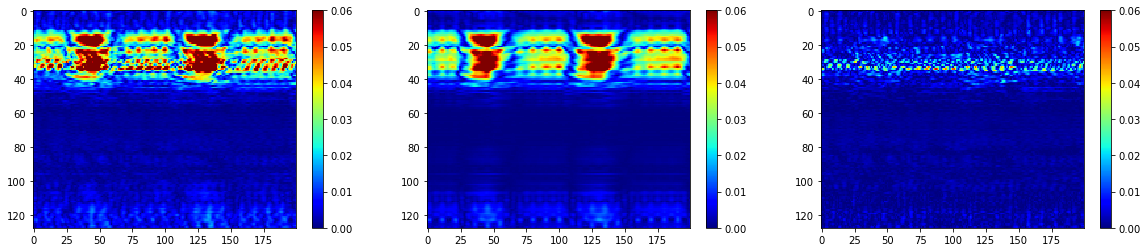

In [15]:
def KL_div(means: torch.Tensor, log_var: torch.Tensor) -> torch.Tensor:
    KLD = -0.5 * torch.sum(1 + log_var - means**2 -  log_var.exp())
    return KLD

import matplotlib.pyplot as plt
from numpy import random
smoothness = 0.0
batch_sz = 1
scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.95, patience=200, verbose=True, min_lr=1e-8)
means = None
nav_hat = None
for epoch in range(20000):
    if epoch == 5000:
        lam = 2e-8
    opt.zero_grad()
    nav_hat, means, log_var, z = lm_network(navT[:, :])
        
    MEANS = torch.fft.fftshift(torch.fft.fft(means, axis=0), axis=0)
    filtered_means = abs(torch.fft.ifftshift(MEANS * BadBand, axis=0))
    
    data_loss = loss_fn(torch.view_as_real(torch.fft.fft(nav_hat, axis=0)), torch.view_as_real(torch.fft.fft(navT[:, :], axis=0)))
    smoothness = torch.norm(filtered_means, p=2.0) #+ 1e-3 * torch.norm(filtered_sparse_means, p=1.0)
    if epoch > 100:
        loss =  data_loss + lam * smoothness #+ 1e-4 * KL_div(means, log_var)# + lam * smoothness
    else:
        loss = data_loss
        
    loss.backward()
    opt.step()
    #scheduler.step(loss.detach().cpu().numpy())
    if(np.mod(epoch, 1500) == 499):
        plt.figure()
        print("Data: ",data_loss.item(),"Total: ",loss.item())
        fig, ax = plt.subplots(1,3,figsize=(20,4))
        ax[0].plot(navT[20:-20,2].cpu().numpy())
        ax[0].plot(nav_hat[...,2].detach().cpu().numpy())
        ax[1].plot(navT[20:-20,7].cpu().numpy())
        ax[1].plot(nav_hat[...,7].detach().cpu().numpy())
        ax[2].plot((means[0:200, :].detach().cpu().numpy()))
        fig, ax = plt.subplots(1, 3, figsize=(20, 4))
        nav_im = abs(torch.view_as_complex((navT.reshape([nav.shape[0], 2, -1]).permute([0, 2, 1])).contiguous()).cpu().numpy())
        im = ax[0].imshow(nav_im[:200, 128:256].T, vmin=-0.00, vmax=0.06, interpolation='nearest', aspect='auto', cmap='jet')
        plt.colorbar(im, ax=ax[0])
        nav_im_hat = abs(torch.view_as_complex((nav_hat.reshape([nav.shape[0], 2, -1]).permute([0, 2, 1])).contiguous()).detach().cpu().numpy())
        im = ax[1].imshow(nav_im_hat[:200, 128:256].T, vmin=-0.00, vmax=0.06, interpolation='nearest', aspect='auto', cmap='jet')
        plt.colorbar(im, ax=ax[1])
        im = ax[2].imshow(abs(nav_im[:200, 128:256] - nav_im_hat[:200, 128:256]).T, vmin=0.0, vmax=0.06, interpolation='nearest', aspect='auto', cmap='jet')
        plt.colorbar(im, ax=ax[2])
        plt.show()
        
means = means.detach().clone()

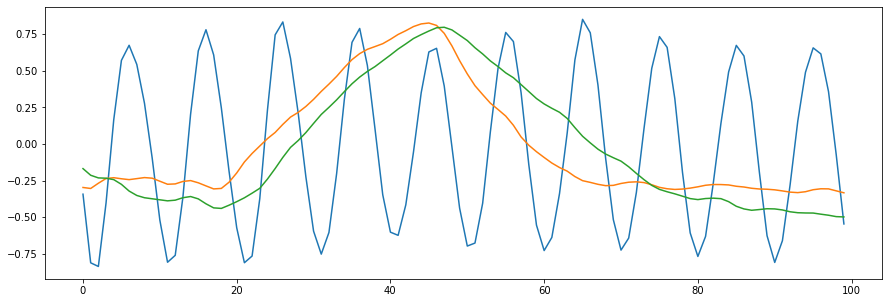

<Figure size 432x288 with 0 Axes>

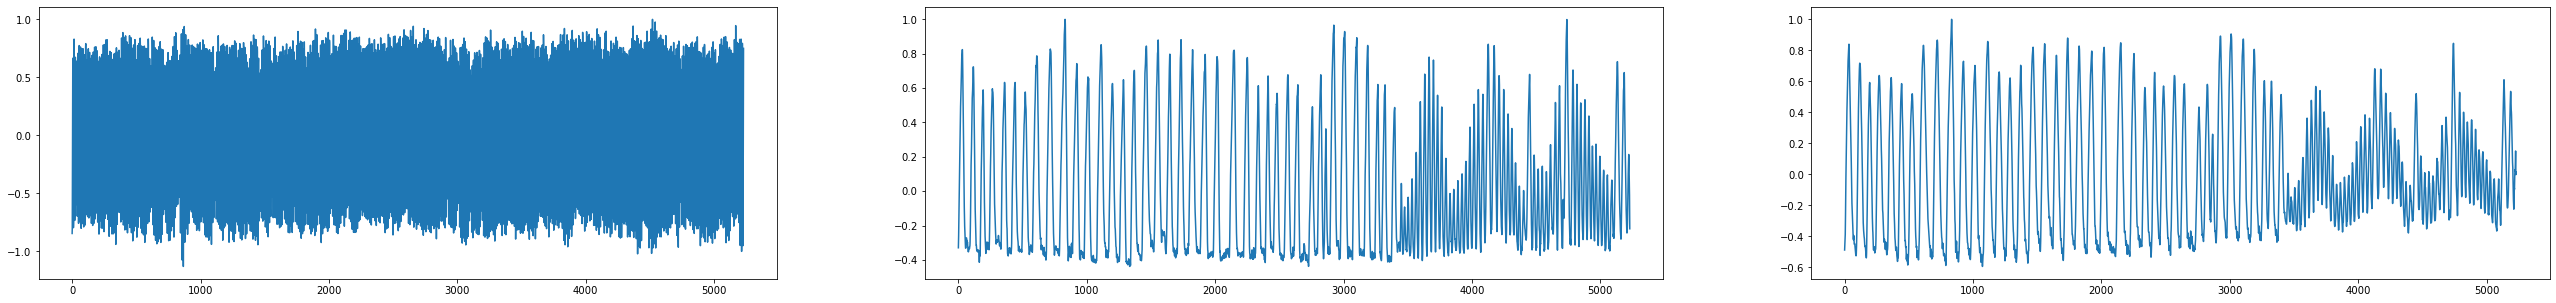

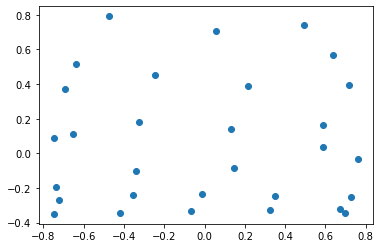

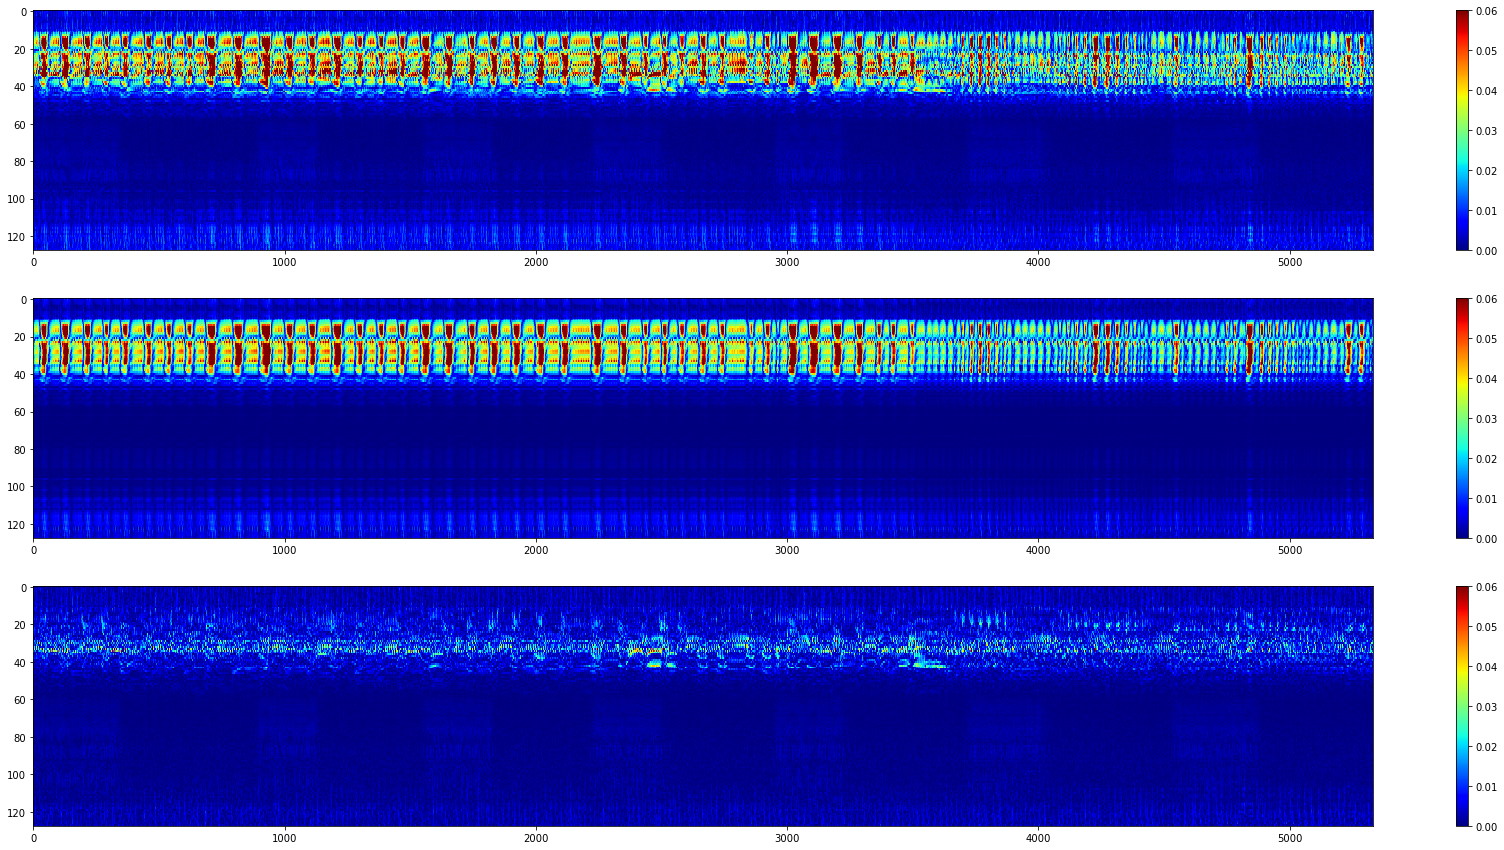

In [16]:
from sklearn.cluster import KMeans as clustering
        
means = means.detach().clone()

device = torch.device(gpu_id)

plt.figure(figsize=(15,5))
z = norm(means.cpu().numpy())
plt.plot(z[0:100, ...])
plt.show()
z = (norm(means.cpu().numpy()))

plt.figure()#figsize=(15,5))
fig, ax = plt.subplots(1, 3, figsize=(45, 5))
ax[0].plot(z[100:, 0])
ax[1].plot(z[100:, 1])
ax[2].plot(z[100:, 2])
plt.show()

n_cl = 30
z_uc = z
clusters = clustering(n_clusters=n_cl, init='k-means++').fit(z)
plt.figure()
plt.scatter(clusters.cluster_centers_[:, 0], clusters.cluster_centers_[:, 1])
plt.show()

labels = torch.tensor(clusters.labels_)
z = torch.tensor(clusters.cluster_centers_)

fig, ax = plt.subplots(3, 1, figsize=(30, 15))
nav_im = abs(torch.view_as_complex((navT.reshape([nav.shape[0], 2, -1]).permute([0, 2, 1])).contiguous()).cpu().numpy())
im = ax[0].imshow(nav_im[:, 128:256].T, vmin=-0.00, vmax=0.06, interpolation='nearest', aspect='auto', cmap='jet')
plt.colorbar(im, ax=ax[0])
nav_im_hat = abs(torch.view_as_complex((nav_hat.reshape([nav.shape[0], 2, -1]).permute([0, 2, 1])).contiguous()).detach().cpu().numpy())
im = ax[1].imshow(nav_im_hat[:, 128:256].T, vmin=-0.00, vmax=0.06, interpolation='nearest', aspect='auto', cmap='jet')
plt.colorbar(im, ax=ax[1])
im = ax[2].imshow(abs(nav_im[:, 128:256] - nav_im_hat[:, 128:256]).T, vmin=0.0, vmax=0.06, interpolation='nearest', aspect='auto', cmap='jet')
plt.colorbar(im, ax=ax[2])
plt.show()


In [17]:

device = torch.device(gpu_id)

class A_operator(nn.Module):
    def __init__(self, s_map: np.array, coords: np.array, size=[256, 256, 256]) -> None:
        super().__init__()
        
        S = sp.linop.Multiply([1, size[0], size[1], size[2]], s_map)
        coords = np.array([size[0]/2, size[1]/2, size[2]/2]).reshape([1, 3]) * coords / np.max(coords.reshape([-1,3]), axis=0).reshape([1, 3])
        F = sp.linop.NUFFT([nvcoils, size[0], size[1], size[2]], coords)
        A = F * S
        self.Asp = A
        self.A = sp.to_pytorch_function(A, input_iscomplex=True, output_iscomplex=True)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ksp = self.A.apply(x.unsqueeze(0))
        return ksp
    
class S_operator(nn.Module):
    def __init__(self, s_map: np.array) -> None:
        super().__init__()
        
        S = sp.linop.Multiply([1, 256, 256, 256], s_map)
        self.S = sp.to_pytorch_function(S, input_iscomplex=True, output_iscomplex=True)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        coilImages = self.S.apply(x.unsqueeze(0))
        return coilImages
    
class W_operator(nn.Module):
    def __init__(self, dcf: np.array, shape) -> None:
        super().__init__()
        
        dcf = dcf.reshape([-1, dcf.shape[0]])
        dcf = dcf.permute([1, 0]).unsqueeze(-1).unsqueeze(-1).cpu().numpy()
        
        dcf = dcf / np.max(abs(dcf)[:])
        
        W = np.sqrt(dcf)
        W = sp.linop.Multiply(shape, W)
        
        self.W = sp.to_pytorch_function(W, input_iscomplex=False, output_iscomplex=False)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.W.apply(x)
    
from typing import List

class TV_operator(nn.Module):
    def __init__(self, ishape: List[int]) -> None:
        super().__init__()
        
        com_mask = sp.linop.Multiply(ishape, np.array([fov_x/160.0, fov_y/160.0, fov_z/160.0]).reshape([3, 1, 1, 1]))
        TV = sp.linop.FiniteDifference(ishape, axes=[-1, -2, -3])
        self.TV = sp.to_pytorch_function(com_mask, input_iscomplex=False, output_iscomplex=False)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.TV.apply(x)
    
dcf = data['dcf']

net = gen()
net.weight_init()

b = kspCombine[:, :, :].transpose([1, 0, 2]).reshape([-1, ksp.shape[0], nvcoils])
b = b[25:-25, ...]
b = b[18:-1, ...] 
b = torch.view_as_real(torch.tensor(b))# / np.max(abs(ksp[:]))

trajectory_t = trajectory.transpose([1, 0, 2]).reshape([-1, trajectory.shape[0], 3])
trajectory_t = trajectory_t[25:-25, :, :]
trajectory_t = trajectory_t[18:-1, ...]
trajectory_t = torch.tensor(trajectory_t)

dcf_t = dcf.squeeze().transpose([1, 0]).reshape([-1, dcf.shape[0]])
dcf_t = dcf_t[25:-25, :]
dcf_t = dcf_t[18:-1, ...]
dcf_t = torch.tensor(dcf_t)

z_tensor = torch.normal(mean=torch.ones([b.shape[1]]), std=torch.ones([b.shape[1]])).clone()
z_tensor.requires_grad = True
z = nn.Parameter(z)
z.requires_grad = True
x_tensor = torch.normal(mean=torch.ones(ssr.shape), std=torch.ones(ssr.shape)).clone()
x_tensor = torch.view_as_real(torch.complex(x_tensor, torch.normal(mean=torch.ones(ssr.shape), std=torch.ones(ssr.shape))).type(torch.complex128)).double().to(device)
x_tensor.requires_grad = True
x = nn.Parameter(x_tensor)
x.requires_grad = True

loss_fn = nn.MSELoss()

device = torch.device(gpu_id)
bat_sz = 1

net = net.to(device)
z = z.to(device)

def index_tensor_with_labels(x: torch.tensor, index, labels, axis: int) -> torch.tensor:
    
    assert(labels.shape[0] == x.shape[axis])
    
    indices = torch.range(0, labels.shape[0] - 1)
    mask = (labels == index)
    indices = mask * (indices + 1)
    indices = indices[indices != 0]
    indices = torch.floor(indices - 1).type(torch.long)

    return torch.index_select(x, axis, indices)

def filter_to_band(ksp: torch.Tensor, dcf: torch.Tensor, trajectory: torch.Tensor, size=256) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
    
    idx = torch.sqrt(torch.sum(trajectory**2,axis=-1)) <= 0.5 * (size - 10) / (384)
    return (ksp[idx].unsqueeze(0), dcf[idx].unsqueeze(0), trajectory[idx].unsqueeze(0))
    

/Users/jwkettelkamp/miniconda/envs/factornet_env/lib/python3.6/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811805959/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


/Users/jwkettelkamp/miniconda/envs/factornet_env/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


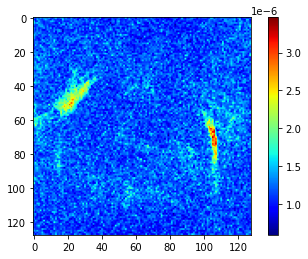

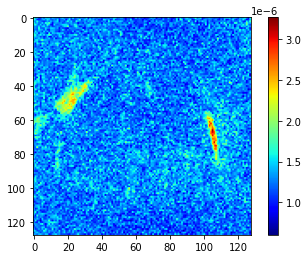

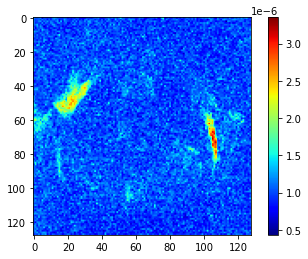

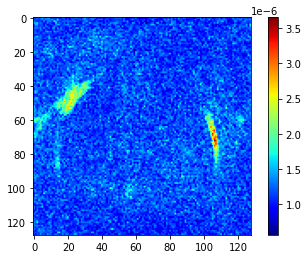

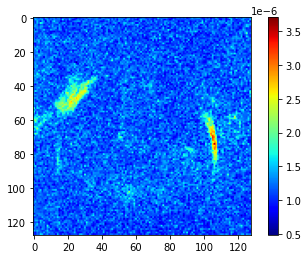

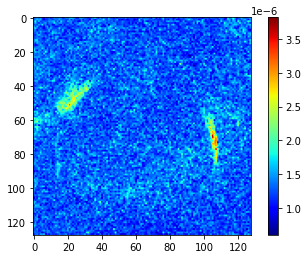

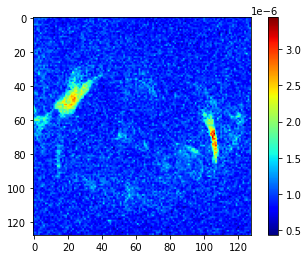

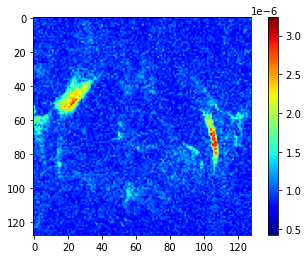

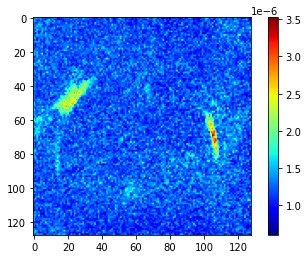

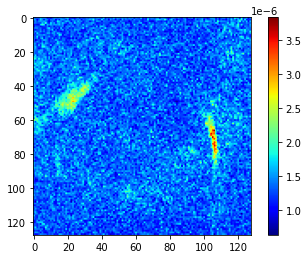

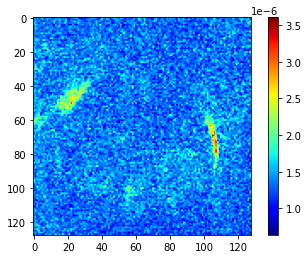

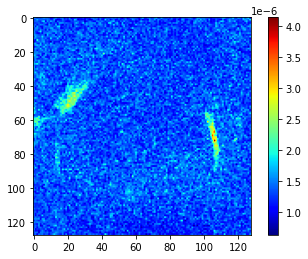

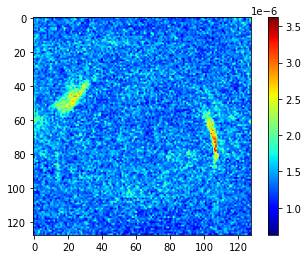

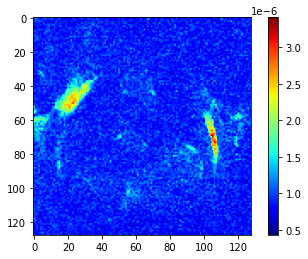

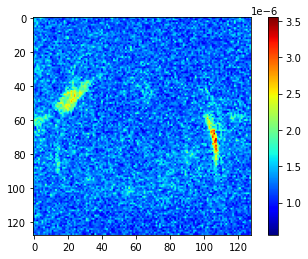

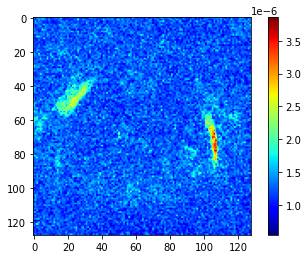

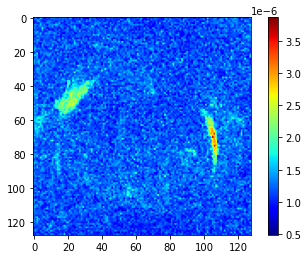

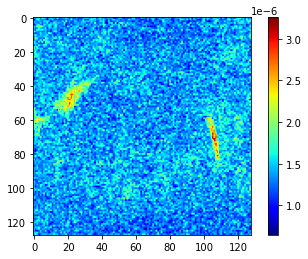

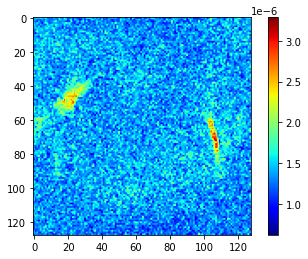

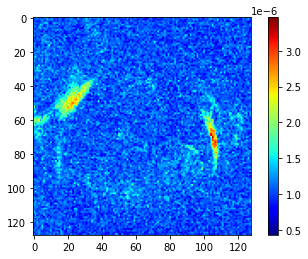

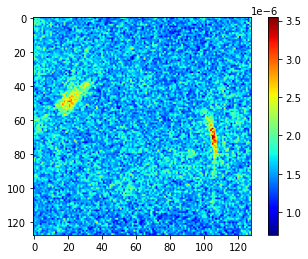

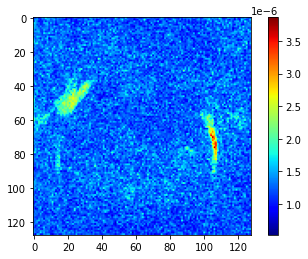

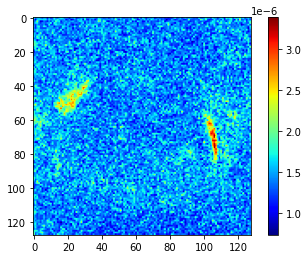

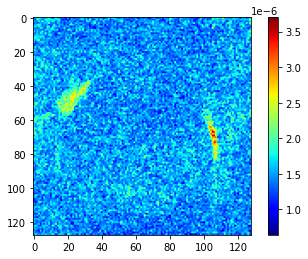

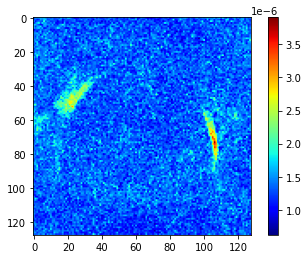

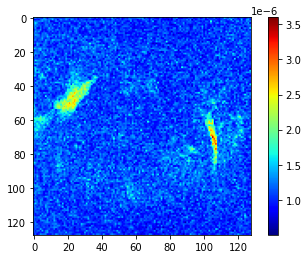

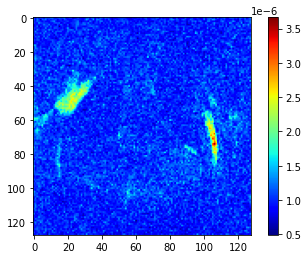

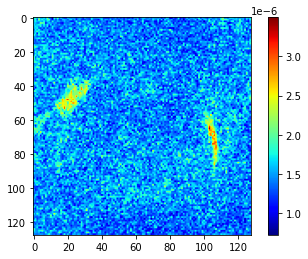

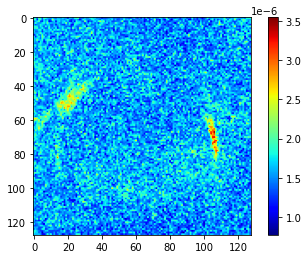

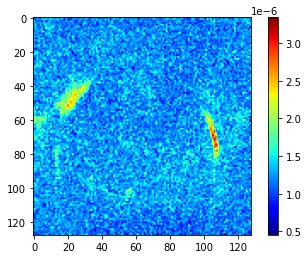

In [18]:
b = b / torch.max(abs(b[:]))
Atb = None

Atb = list()

with cp.cuda.Device(gpu_id):
    mempool.free_all_blocks()  # 5 GiB

for cluster in range(n_cl):
    
    recon_cl = None
    s_map_cl = None

    with sp.Device(gpu_id) as device:
        cluster_trj = index_tensor_with_labels(trajectory_t, cluster, labels, 0).numpy()
        cluster_trj = np.array([425/2, 425/2, 425/2]).reshape([1, 3]) * cluster_trj / np.max(cluster_trj.reshape([-1,3]), axis=0).reshape([1, 3])
        cluster_trj = cp.array(cluster_trj)
        cluster_ksp = cp.array(index_tensor_with_labels(dcf_t, cluster, labels, 0).unsqueeze(-1)) * cp.array(torch.view_as_complex(index_tensor_with_labels(b, cluster, labels, 0)).numpy())
        cluster_ksp = cluster_ksp / cluster_ksp.shape[0]
        A = sp.linop.NUFFTAdjoint([nvcoils, 128, 128, 128], cluster_trj)
        cluster_recon = A(cluster_ksp.transpose([2, 0, 1]))
        recon_cl = cluster_recon.get()
        Atb.append(recon_cl)
        
    with cp.cuda.Device(gpu_id):
        mempool.free_all_blocks()  # 5 GiB
        
    plt.figure()
    plt.imshow(np.sqrt(np.mean((abs(np.sum(np.square(recon_cl), axis=0))[ :, 55:60, :]),axis=1)).transpose([1,0]), cmap='jet')
    plt.colorbar()
    plt.show()

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
class X(nn.Module):
    def __init__(self, x_init: torch.Tensor) -> None:
        super().__init__()
        
        print(x_init.shape)
        
        
        self.x = nn.Parameter(torch.view_as_real(torch.complex(torch.norm(x_init, p=2.0, dim=0).reshape([1, 256, 256, 256]), torch.zeros(1, 256, 256, 256).double())).permute([0, 4, 1, 2, 3]).float())
        
    def forward(self, size=256) -> torch.Tensor:
        if size == 256:
            return self.x
        
        return F.interpolate(self.x, size=[size, size, size])
    

In [20]:
x = X(torch.zeros(1, 256, 256, 256).double())

torch.Size([1, 256, 256, 256])


In [21]:
opt = optim.Adam([{'params': filter(lambda p: p.requires_grad, net.parameters()), 'lr': 1e-5}, 
                  {'params': filter(lambda p: p.requires_grad, x.parameters()), 'lr': 2e-2}], betas=(0.4, 0.999))

In [23]:
torch.autograd.set_detect_anomaly(True)
#print(filter(lambda p: p.requires_grad, x.parameters()))
import cupy
import sigpy
from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(opt, mode='min', factor=0.90, patience=50, verbose=True, min_lr=1e-8)

device = torch.device(gpu_id)
x = x.to(device)

total_interleaves = b.shape[1]
recon = None
s_map = s_map / np.max(abs(s_map[:]))
epoches = [10, 50, 50, 50, 100, 200]
net = net.to(device)
b = b / torch.max(abs(b[:]))
avg_recon_tensor = torch.tensor(avg_recon).to(device)

max_eigen_value = 0.0
for cluster in range(n_cl):
    A = A_operator(s_map, index_tensor_with_labels(trajectory_t, cluster, labels, 0).numpy())
    AFunctional = A.Asp
    W = sp.linop.Multiply(AFunctional.oshape, index_tensor_with_labels(dcf_t, cluster, labels, 0).numpy())
    largest_eigen_value = sp.app.MaxEig(AFunctional.H * W * AFunctional, max_iter=3, dtype=np.complex128, device=sp.Device(gpu_id), show_pbar=False).run()
    max_eigen_value = max(max_eigen_value, largest_eigen_value)

dcf = dcf/max_eigen_value
    
with cp.cuda.Device(gpu_id):
    mempool.free_all_blocks()  # 5 GiB
    

/Users/jwkettelkamp/miniconda/envs/factornet_env/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


torch.Size([30, 3])


/Users/jwkettelkamp/miniconda/envs/factornet_env/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/Users/jwkettelkamp/miniconda/envs/factornet_env/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


Done initializing data Object !!
Max GPU utilization 8.09117952  GB 
Current GPU utilization 5.425671680000001  GB 
Total GPU memory available 212.32304128  GB 


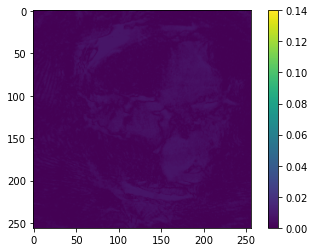

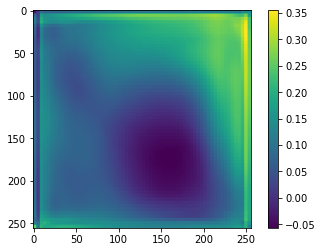

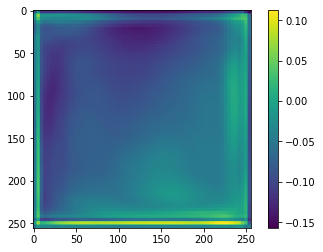

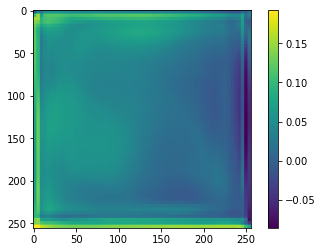

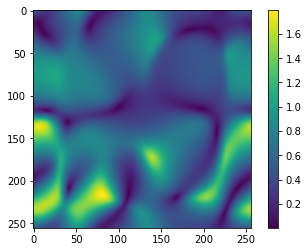

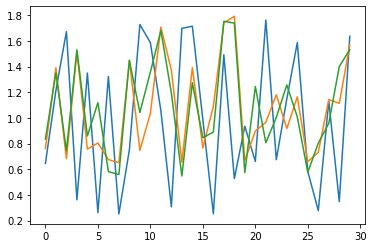

/Users/jwkettelkamp/miniconda/envs/factornet_env/lib/python3.6/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/Users/jwkettelkamp/miniconda/envs/factornet_env/lib/python3.6/site-packages/ipykernel_launcher.py:101: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).


In [ ]:
print(z.shape)
z = z + 1.0
import random
bat_sz = 2
device = torch.device(gpu_id)
net.to(device)
mode_cl = 0
count_max = 0
size = 256
net.resize_output(size)
for cluster in range(n_cl):
    count = torch.sum(1.0 * (labels == cluster).double())
    if count > count_max:
        mode_cl = cluster
        count_max = count
for epochs in range(225, 650):
    loss = None
    epocherror = 0.0
    if epochs == 0:
        opt.param_groups[0]['lr'] = 1e-4 
        opt.param_groups[1]['lr'] = 4e-4
        #size = 128
        net.resize_output(size)
    if epochs == 95:
        #size = 128
        net.resize_output(size)
    elif(epochs < 0):
        opt.param_groups[0]['lr'] = 0
        opt.param_groups[1]['lr'] = 2e-2
        #size = 256
        net.resize_output(size)
    elif(epochs == 225):
        opt.param_groups[0]['lr'] = 1e-4
        opt.param_groups[1]['lr'] = 2e-4
        #size = 256
        net.resize_output(size)
    s_map_sam = None
    if size != 256:
        s_map_sam = torch.view_as_complex(F.interpolate(torch.view_as_real(torch.tensor(s_map).to(device)).permute([4, 0, 1, 2, 3]), size=[size, size, size]).permute([1, 2, 3, 4, 0]).contiguous()).cpu().numpy()
    else:
        s_map_sam = s_map
        
    for bat in range(int(n_cl/bat_sz)):
        opt.zero_grad()
        indices = random.sample(range(n_cl), bat_sz)
        #print(x(size).shape)
        recon = net(z[indices].to(device).reshape([-1, 3, 1, 1, 1]), x(size).repeat(bat_sz, 1, 1, 1, 1)).permute([0, 2, 3, 4, 1]).contiguous().squeeze(0)
        loss = torch.zeros(1).to(device)
        loss.require_grads = True
        i = 0
        for cluster in indices:
            dcf_sub = index_tensor_with_labels(dcf_t, cluster, labels, 0)
            trj_sub = index_tensor_with_labels(trajectory_t, cluster, labels, 0)
            b_sub = index_tensor_with_labels(b, cluster, labels, 0).to(device).double() / b.shape[0]
        
            b_sub, dcf_sub, trj_sub = filter_to_band(b_sub, dcf_sub, trj_sub, size)
            
            A = A_operator(s_map_sam, trj_sub.numpy(), [size, size, size])
            TV = TV_operator([size, size, size])
            TV_flow = TV_operator([3, size, size, size]).to(device)
            TV.to(device)
            TV_loss = None
            if cluster == mode_cl:
                TV_loss = 3e-4 * torch.norm(torch.norm(TV(abs(torch.view_as_complex(x(size).squeeze().permute([1, 2, 3, 0]).contiguous()))), p=2.0, dim=0), p=1.0)
                TV_loss = TV_loss + 1e-7 * torch.norm(torch.norm(TV_flow(abs(net.flow[i])), p=2.0, dim=0), p=1.0)
            else:
                TV_loss = 3e-4 * torch.norm(torch.norm(TV(abs(torch.view_as_complex(x(size).squeeze().permute([1, 2, 3, 0]).contiguous()))), p=2.0, dim=0), p=1.0)
                TV_loss = TV_loss + 2e-9 * torch.norm(torch.norm(TV_flow(abs(net.flow[i])), p=2.0, dim=0), p=1.0)
            
            Ax = A(recon[i]).permute([1, 2, 0, 3])
      
            W = W_operator(dcf_sub, b_sub.shape)
       
            loss = loss + torch.norm(W(Ax.double() - 25000 * b_sub), p=2.0)# + 1e-4 * torch.sum(torch.view_as_real(mask.to(device) * torch.view_as_complex(recon)) ** 2) 
            loss = loss + TV_loss
            
            i+=1
        loss.backward()
        epocherror += loss.detach()
        opt.step()
    scheduler.step(epocherror)
        
    if np.mod(epochs, 25) == 1:
        print("Done initializing data Object !!")
        max_memory = torch.cuda.max_memory_allocated(device=device) * 1e-9
        print("Max GPU utilization", max_memory, " GB ")
        current_memory = torch.cuda.memory_allocated(device=device) * 1e-9
        print("Current GPU utilization", current_memory, " GB ")
        available_memory = torch.cuda.get_device_properties(device=device).total_memory * 2.5e-9
        print("Total GPU memory available", available_memory, " GB ")
        if (current_memory > available_memory * 0.5):
            print("You may have to switch off fastMode to conserve GPU memory")
        plt.figure()
        rel = recon.shape[2]
        plt.imshow(abs(torch.view_as_complex(recon[0,:,int(110 * rel / 256.0), :])).detach().cpu().numpy(), vmax=0.14, vmin=0.0)
        plt.colorbar()
        plt.figure()
        plt.imshow((net.flow[0, 0, :,int(110 * rel / 256.0), :]).detach().cpu().numpy())
        plt.colorbar()
        plt.figure()
        plt.imshow((net.flow[0, 1, :,int(110 * rel / 256.0), :]).detach().cpu().numpy())
        plt.colorbar()
        plt.figure()
        plt.imshow((net.flow[0, 2, :,int(110 * rel / 256.0), :]).detach().cpu().numpy())
        plt.colorbar()
        plt.figure()
        plt.imshow(abs(np.sum(s_map, axis=0))[:,int(110 * rel / 256.0), :])
        plt.colorbar()
        plt.figure()
        plt.plot(z.detach().cpu().numpy())
        plt.show()

In [ ]:
torch.save(net.state_dict(), 'siemens_moco3_test.pt')
torch.save(x.state_dict(), 'reconstruction_siemens3_test.pt')

np.save('z_uc3.npy', z_uc)

In [ ]:
import sys
import numpy as np
import torch
%load_ext autoreload
%reload_ext autoreload
%autoreload 2 

gpu_id = 1

import p_dicom as dicom
z_uc = np.load('z_uc3.npy')

params = {'patient_name': 'Siemens_3D_Lung_recon_with_moco_storm',
          'modality': 'MR',
          'body_part': 'CHEST',
          'scan_options': '3D',
          'scan_time': 3000.0,
          'frame_count': z_uc[1000:1500, ...].shape[0],
          'generator_file': 'siemens_moco3_test.pt',
          'template_file': 'reconstruction_siemens3_test.pt',
          'output_folder': './dicom_results_small_3/', 
          'device': torch.device(1)
         }
import ipyparallel as ipp

with ipp.Cluster(n=4) as cl:
    pool = dicom.write_pool(cl)
    pool.run((torch.tensor(z_uc[1000:1500, ...]) + 1.0).reshape([-1, 3, 1, 1, 1]), params)

In [ ]:
net.resize_output(256)
device = torch.device(gpu_id)
z_s = torch.sort(z.squeeze(), axis=0)
z = z_s[0].to(device)
net.to(device)
x.to(device)
movie_array = np.zeros([6, n_cl, 256, 256])
net.eval().to(device)
x.eval()
for cluster in range(n_cl):
    recon = net(z[cluster].reshape([1, 3, 1, 1, 1]), x()).permute([0, 2, 3, 4, 1]).contiguous().squeeze(0)
    idx = [80,100,110, 120, 140, 144]
    movie_array[:, cluster, :, :] = abs(torch.view_as_complex(recon)).detach().cpu().numpy()[::-1, idx, ::-1].transpose([1, 0, 2])
    
plt.figure()
plt.plot(z[:, :].detach().cpu().numpy())
plt.show()

In [ ]:
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

data = movie_array[..., :, :]

fig, ax = plt.subplots(1, 6, figsize=(5*6, 5))

im1 = ax[0].imshow(data[0, 0,:,:], vmax=0.15, cmap='gray')
plt.colorbar(im1, ax=ax[0])
im2 = ax[1].imshow(data[1, 0,:,:], vmax=0.15, cmap='gray')
plt.colorbar(im2, ax=ax[1])
im3 = ax[2].imshow(data[2, 0,:,:], vmax=0.15, cmap='gray')
plt.colorbar(im3, ax=ax[2])
im4 = ax[3].imshow(data[3, 0,:,:], vmax=0.15, cmap='gray')
plt.colorbar(im4, ax=ax[3])
im5 = ax[4].imshow(data[4, 0,:,:], vmax=0.15, cmap='gray')
plt.colorbar(im5, ax=ax[4])
im6 = ax[5].imshow(data[5, 0,:,:], vmax=0.15, cmap='gray')
plt.colorbar(im6, ax=ax[5])

def init():
    im1.set_data(data[0, 0,:,:])
    im2.set_data(data[1, 0,:,:])
    im3.set_data(data[2, 0,:,:])
    im4.set_data(data[3, 0,:,:])
    im5.set_data(data[4, 0,:,:])
    im6.set_data(data[5, 0,:,:])
    return (im1, im2, im3, im4, im5, im6,)

# animation function. This is called sequentially
def animate(i):
    #i = int(n_cl * i/ncoil)
    data_slice = data[0, i,:,:]
    im1.set_data(data_slice)
    data_slice = data[1, i,:,:]
    im2.set_data(data_slice)
    data_slice = data[2, i,:,:]
    im3.set_data(data_slice)
    data_slice = data[3, i,:,:]
    im4.set_data(data_slice)
    data_slice = data[4, i,:,:]
    im5.set_data(data_slice)
    data_slice = data[5, i,:,:]
    im6.set_data(data_slice)
    return (im1, im2, im3, im4, im5, im6,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=n_cl, interval=80, blit=True)
anim.save('limited3.gif')
HTML(anim.to_jshtml())


In [ ]:
device = torch.device(gpu_id)
z = torch.sort(z.squeeze())
z = z[0].reshape([n_cl, 3])
movie_array = np.zeros([6, z_uc.shape[0], 150, 150])
movie_array_flow = np.zeros([6, z_uc.shape[0], 150, 150, 3])
z_un = torch.tensor(z_uc) + 1.0
plt.figure()
plt.plot(z_uc)
plt.show()
for i in range(500):
    recon = net(z_un[i].to(device).reshape([1, 3, 1, 1, 1]), x()).permute([0, 2, 3, 4, 1]).contiguous().squeeze(0)

    idx = [110, 112, 118, 122, 126, 130]
    movie_array_flow[:, i, :, :, :] = net.flow.squeeze().permute([3, 1, 2, 0]).detach().cpu().numpy()[:, idx, :, ...].transpose([1, 2, 0, 3])[..., 70:220, 50:200, :]
    movie_array[:, i, :, :] = abs(torch.view_as_complex(recon)).detach().cpu().numpy()[:, idx, :].transpose([1, 2, 0])[..., 70:220, 50:200]

In [ ]:
from IPython.display import HTML
import numpy as np
#matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.embed_limit'] = 2**256

data = movie_array[..., :, :]
data_flow = movie_array_flow[..., :, :]
mask = np.ones([1, 1, 1, 1])

fig, ax = plt.subplots(4, 7, figsize=(5*7, 5 * 4))

#image block
im1 = ax[0,0].imshow(data[0, 0,:,:], cmap='gray')
plt.colorbar(im1, ax=ax[0,0])
im2 = ax[0,1].imshow(data[1, 0,:,:], cmap='gray')
plt.colorbar(im2, ax=ax[0,1])
im3 = ax[0,2].imshow(data[2, 0,:,:], cmap='gray')
plt.colorbar(im3, ax=ax[0,2])
im4 = ax[0,3].imshow(data[3, 0,:,:], cmap='gray')
plt.colorbar(im4, ax=ax[0,3])
im5 = ax[0,4].imshow(data[4, 0,:,:], cmap='gray')
plt.colorbar(im5, ax=ax[0,4])
im6 = ax[0,5].imshow(data[5, 0,:,:], cmap='gray')
plt.colorbar(im6, ax=ax[0,5])

#flow x block
im7 = ax[1,0].imshow(data_flow[0, 0,:,:, 0], cmap='gray')
plt.colorbar(im1, ax=ax[1,0])
im8 = ax[1,1].imshow(data_flow[1, 0,:,:, 0], cmap='gray')
plt.colorbar(im2, ax=ax[1,1])
im9 = ax[1,2].imshow(data_flow[2, 0,:,:, 0], cmap='gray')
plt.colorbar(im3, ax=ax[1,2])
im10 = ax[1,3].imshow(data_flow[3, 0,:,:, 0], cmap='gray')
plt.colorbar(im4, ax=ax[1,3])
im11 = ax[1,4].imshow(data_flow[4, 0,:,:, 0], cmap='gray')
plt.colorbar(im5, ax=ax[1,4])
im12 = ax[1,5].imshow(data_flow[5, 0,:,:, 0], cmap='gray')
plt.colorbar(im6, ax=ax[1,5])

#flow y block
im13 = ax[2,0].imshow(data_flow[0, 0,:,:, 1], cmap='gray')
plt.colorbar(im1, ax=ax[2,0])
im14 = ax[2,1].imshow(data_flow[1, 0,:,:, 1], cmap='gray')
plt.colorbar(im2, ax=ax[2,1])
im15 = ax[2,2].imshow(data_flow[2, 0,:,:, 1], cmap='gray')
plt.colorbar(im3, ax=ax[2,2])
im16 = ax[2,3].imshow(data_flow[3, 0,:,:, 1], cmap='gray')
plt.colorbar(im4, ax=ax[2,3])
im17 = ax[2,4].imshow(data_flow[4, 0,:,:, 1], cmap='gray')
plt.colorbar(im5, ax=ax[2,4])
im18 = ax[2,5].imshow(data_flow[5, 0,:,:, 1], cmap='gray')
plt.colorbar(im6, ax=ax[2,5])

#flow z block
im19 = ax[3,0].imshow(data_flow[0, 0,:,:, 2], cmap='gray')
plt.colorbar(im1, ax=ax[3,0])
im20 = ax[3,1].imshow(data_flow[1, 0,:,:, 2], cmap='gray')
plt.colorbar(im2, ax=ax[3,1])
im21 = ax[3,2].imshow(data_flow[2, 0,:,:, 2], cmap='gray')
plt.colorbar(im3, ax=ax[3,2])
im22 = ax[3,3].imshow(data_flow[3, 0,:,:, 2], cmap='gray')
plt.colorbar(im4, ax=ax[3,3])
im23 = ax[3,4].imshow(data_flow[4, 0,:,:, 2], cmap='gray')
plt.colorbar(im5, ax=ax[3,4])
im24 = ax[3,5].imshow(data_flow[5, 0,:,:, 2], cmap='gray')
plt.colorbar(im6, ax=ax[3,5])

#latent block
l, = ax[0, 6].plot(z_uc[0:500, 1])
l2, = ax[0, 6].plot(z_uc[0:500, 0])
v = ax[0, 6].axvline(x=0)

def init():
    im1.set_data(data[0, 0,:,:])
    im2.set_data(data[1, 0,:,:])
    im3.set_data(data[2, 0,:,:])
    im4.set_data(data[3, 0,:,:])
    im5.set_data(data[4, 0,:,:])
    im6.set_data(data[5, 0,:,:])
    
    im7.set_data(data_flow[0, 0,:,:, 0])
    im8.set_data(data_flow[1, 0,:,:, 0])
    im9.set_data(data_flow[2, 0,:,:, 0])
    im10.set_data(data_flow[3, 0,:,:, 0])
    im11.set_data(data_flow[4, 0,:,:, 0])
    im12.set_data(data_flow[5, 0,:,:, 0])
    
    im13.set_data(data_flow[0, 0,:,:, 1])
    im14.set_data(data_flow[1, 0,:,:, 1])
    im15.set_data(data_flow[2, 0,:,:, 1])
    im16.set_data(data_flow[3, 0,:,:, 1])
    im17.set_data(data_flow[4, 0,:,:, 1])
    im18.set_data(data_flow[5, 0,:,:, 1])
    
    im19.set_data(data_flow[0, 0,:,:, 2])
    im20.set_data(data_flow[1, 0,:,:, 2])
    im21.set_data(data_flow[2, 0,:,:, 2])
    im22.set_data(data_flow[3, 0,:,:, 2])
    im23.set_data(data_flow[4, 0,:,:, 2])
    im24.set_data(data_flow[5, 0,:,:, 2])
    
    #l.set_data(means.cpu().numpy())
    return (im1, im2, im3, im4, im5, im6, im7, im8, im9, im10, im11, im12, im13, im14, im15, im16, im17, im18, im19, im20, im21, im22, im23, im24, l, v,)

# animation function. This is called sequentially
def animate(i):
    #i = int(n_cl * i/24)
    data_slice = data[0, i,:,:]
    im1.set_data(data_slice)
    data_slice = data[1, i,:,:]
    im2.set_data(data_slice)
    data_slice = data[2, i,:,:]
    im3.set_data(data_slice)
    data_slice = data[3, i,:,:]
    im4.set_data(data_slice)
    data_slice = data[4, i,:,:]
    im5.set_data(data_slice)
    data_slice = data[5, i,:,:]
    im6.set_data(data_slice)
    
    data_slice = data_flow[0, i,:,:,0]
    im7.set_data(data_slice)
    data_slice = data_flow[1, i,:,:,0]
    im8.set_data(data_slice)
    data_slice = data_flow[2, i,:,:,0]
    im9.set_data(data_slice)
    data_slice = data_flow[3, i,:,:,0]
    im10.set_data(data_slice)
    data_slice = data_flow[4, i,:,:,0]
    im11.set_data(data_slice)
    data_slice = data_flow[5, i,:,:,0]
    im12.set_data(data_slice)
    
    data_slice = data_flow[0, i,:,:,1]
    im13.set_data(data_slice)
    data_slice = data_flow[1, i,:,:,1]
    im14.set_data(data_slice)
    data_slice = data_flow[2, i,:,:,1]
    im15.set_data(data_slice)
    data_slice = data_flow[3, i,:,:,1]
    im16.set_data(data_slice)
    data_slice = data_flow[4, i,:,:,1]
    im17.set_data(data_slice)
    data_slice = data_flow[5, i,:,:,1]
    im18.set_data(data_slice)
    
    data_slice = data_flow[0, i,:,:,2]
    im19.set_data(data_slice)
    data_slice = data_flow[1, i,:,:,2]
    im20.set_data(data_slice)
    data_slice = data_flow[2, i,:,:,2]
    im21.set_data(data_slice)
    data_slice = data_flow[3, i,:,:,2]
    im22.set_data(data_slice)
    data_slice = data_flow[4, i,:,:,2]
    im23.set_data(data_slice)
    data_slice = data_flow[5, i,:,:,2]
    im24.set_data(data_slice)
    x = v.get_xdata()
    counter = 0
    for item in x:
        x[counter] = item + 1
        counter += 1
    y = v.get_ydata()
    v.set_data(x, y)
    
    return (im1, im2, im3, im4, im5, im6, im7, im8, im9, im10, im11, im12, im13, im14, im15, im16, im17, im18, im19, im20, im21, im22, im23, im24, l, v,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=500, interval=10, blit=True)
anim.save('full_data2_3.gif')
#HTML(anim.to_jshtml())